In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network trained on selected features to descirbe degree of loss for HCMC

The chance of loss is predicted by classifier. The target variable to predict by the BN are the the degree of relative content loss [fraction of content loss and total content value ] for microbusinesses . \
The transferability of the classifer and the BN is tested on the Can Tho dataset

Abbreviations in variables for chance and degre of loss
c = "chance of loss"
d = "degree of loss"
cd = contains "change and degree of loss"

BN package: https://github.com/mike-mendoza/py_banshee

In [2]:
import sys, os
# import logging
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import load

import matplotlib.pyplot as plt
import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


# sys.path.insert(0, "../")
UTILS_PATH = os.path.join(os.path.abspath(""), "../", "utils")
sys.path.append(UTILS_PATH)
import settings as s
import figures as f
import evaluation_utils as eu
import preprocessing as pp

seed = s.seed
pd.set_option("display.max_columns", None)
#plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings("ignore")


targets = [("Target_relative_contentloss_euro", "rcloss"), ("Target_businessreduction","bred")]
target, target_plot = targets[0]
pred_target = f"pred_{target}"


## save models and their evaluation in following folders:
Path(f"../../model_results/bayesian_network/contentloss").mkdir(parents=True, exist_ok=True)


In [3]:
## train set for BN degree of loss (HCMC)
target_name = "contentloss"
df_hcmc_incl_zero = pd.read_excel(f"../model_results/selected_features/degree_of_loss/final_predictors_Target_relative_{target_name}_euro.xlsx")

## LogReg can only use complete sampels , therefore BN has also to predcit only on complete cases
df_hcmc_incl_zero.dropna(inplace=True)
df_hcmc_incl_zero.reset_index(drop=True, inplace=True)  # better for merging different sources, when indexes are all the same

## init df to store later all results from chance and degre of loss, as well as final vulnerability estimation (rcloss)
df_hcmc_pred_cd = df_hcmc_incl_zero.copy()


## drop zero-losses due that they captured by chance of loss , new df only for degree of loss
df_hcmc_d = df_hcmc_incl_zero.loc[df_hcmc_incl_zero[target] > 0.0, :]

print(df_hcmc_d.shape)
df_hcmc_d.tail(2)


# ## load hold out set (HCMC, bred)
# df_hcmc_holdout = pd.read_excel(f"../input_survey_data/input_data_{target_name}_tueb_holdout.xlsx")
# df_hcmc_holdout = df_hcmc_holdout[df_hcmc.columns]  # update only with identified loss-drivers
# # df_hcmc_holdout.drop("geometry", axis=1, inplace=True)
# print(df_hcmc_holdout.shape)
# print(df_hcmc_holdout.tail(2))

df_hcmc_incl_zero.shape

(114, 16)


(294, 16)

### explore condtional correlations

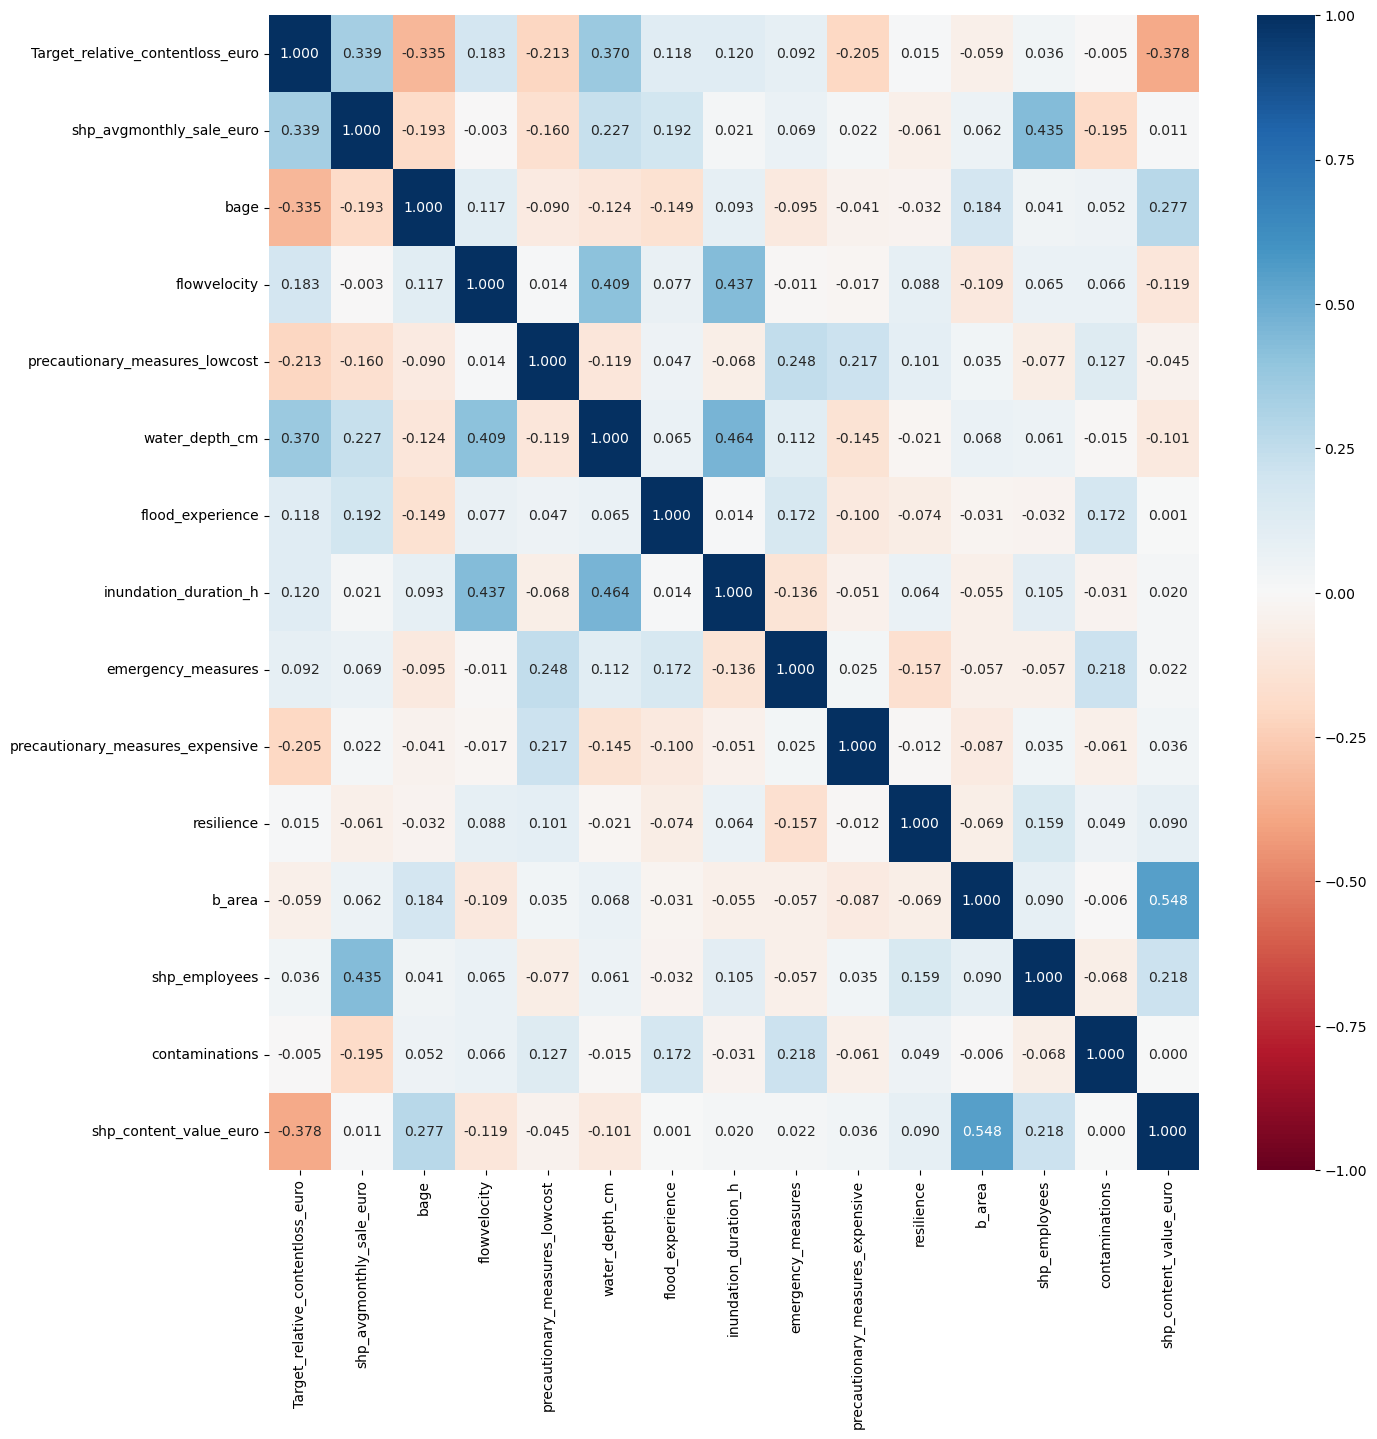

In [4]:
## find predictor with highest unconditional correlation to target
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(df_hcmc_d.drop("geometry", axis=1).corr(method="spearman"), 
                      vmin=-1, vmax=1, 
                      annot=True, fmt=".3f", 
                      cmap="RdBu")

# fv most corr ~ target


--> flowvelo correlates strongest with rcloss

In [5]:
# dd = df_hcmc.loc[df_hcmc.inundation_duration_h < 20, :]
# print(df_hcmc.shape, dd.shape)
# # sns.regplot(x=dd.flowvelocity, y=dd.inundation_duration_h)
# f.plot_correlations(dd[[target, "flowvelocity", "inundation_duration_h", "water_depth_cm"]], 
#                     impute_na=True, outfile=f"../figures/tst.png")

### Copula test

In [6]:
# #-----------------------------------------------------------------------------
# # Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
# #-----------------------------------------------------------------------------

# M = cvm_statistic(df_hcmc,                   # df_predictorsFrame with df_hcmc
##                   names = df_hcmc.columns,   # names of variables
                #   names = df_hcmc_bn.columns,   # names of variables
#                   plot = True,               # create a plot (0=don"t create plot)
                ##   fig_name = "empricial_corpula_all_vars_closs")    # figure name
                #   fig_name = "empricial_corpula_all_vars_degree_rcloss")    # figure name
                  
# # The results of the goodness-of-fit test in terms of Cramer-von Mises
# # statistic highlight that the Gaussian copula is in majority of cases the 
# # most suitable for representing the dependency between variables, 
# # especially for the variable of interest (safety). This is important as
# # the method utilizes the Gaussian copula for dependence modelling.


# ## !! decalibration score = overall score if BN fullfills 

# ### BN visualization

In [7]:
# #-----------------------------------------------------------------------------
# # Function 2 - bn_visualize - Plot of the Bayesian Network
# #-----------------------------------------------------------------------------

# bn_visualize(parent_cell,           # structure of the BN
#              R,                     # the rank correlation matrix (function 1)
#              df_hcmc_bn.columns,          # names of variables
#              fig_name = fig_name)   # figure name
# # The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# # rank correlations indicated on the arcs.

# bn_visualize(parent_cell,                       # structure of the BN
#              R,                                 # the rank correlation matrix 
#              df_hcmc_bn.columns,                      # names of variables
#              data = df_hcmc_bn,                       # DataFrame with data
#              fig_name = fig_name + "_margins")  # figure name
# # The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# # rank correlations indicated on the arcs. In this plot also the marginal
# # distributions for each variable are incorporated.


In [8]:
# #-----------------------------------------------------------------------------
# # Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
# #-----------------------------------------------------------------------------

# M = cvm_statistic(df_hcmc_bn,                   # df_predictorsFrame with df_hcmc
#                   names = df_hcmc_bn.columns,   # names of variables
#                   plot = True,               # create a plot (0=don"t create plot)
#                   fig_name = fig_name)    # figure name
                  
# # The results of the goodness-of-fit test in terms of Cramer-von Mises
# # statistic highlight that the Gaussian copula is in majority of cases the 
# # most suitable for representing the dependency between variables, 
# # especially for the variable of interest (safety). This is important as
# # the method utilizes the Gaussian copula for dependence modelling.


# ## !! decalibration score = overall score if BN fullfills 

In [9]:
# #-----------------------------------------------------------------------------
# # Function 4 - gaussian_distance - measuring d-calibration score
# #-----------------------------------------------------------------------------

# ## TODO fix np.mul() --> fixed with np.mulitply() in d_cal.py from py_banshee package ~ 1h
# ## try to fix, otherwise write with CC Dominik (maybe mixed up respective matlab func()--> )

# # gaussian_distance : validation: 
# D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
#                             R,        # the rank correlation matrix 
#                             df_hcmc_bn,     # df_predictorsFrame with df_hcmc
#                             4000,     # number of samples drawn d-Cal(ERC,NRC)
#                             400,      # number of samples drawn d-Cal(NRC,BNRC)
#                             1000,     # number of iterations to compute CI
#                             Plot=True,          # create a plot (0=don"t create plot)
#                             Type="H",           # take Hellinger distance (default)
#                             fig_name=fig_name)  # figure name

                        
# # draw 4000 samples of the normal distribution and perform 1000 iterations to
# # obtain the distribution of the d-cal score (ERC,NRC)
# # draw 400 samples of the normal distribution and perform 1000 iterations to
# # obtain the distribution of the d-cal score (NRC,BNRC)


# # The d-calibration score of the empirical rank correlation matrix is
# # inside the 90# confidence interval of the determinant of the empirical
# # The d-calibration score of the BN"s rank correlation matrix is well within  
# # the 90# confidence interval of the determinant of the random normal distribution 
# # sampled for the same correlation matrix. This supports the assumptions of
# # a joint normal copula used in the BN model. It should be noted that the 
# # test is sensitive to the number of samples drawn as well as the number of 
# # iterations and is rather severe for large df_predictorssets.


In [10]:
df_hcmc_d.columns

Index(['Target_relative_contentloss_euro', 'shp_avgmonthly_sale_euro', 'bage',
       'flowvelocity', 'precautionary_measures_lowcost', 'water_depth_cm',
       'flood_experience', 'inundation_duration_h', 'emergency_measures',
       'precautionary_measures_expensive', 'resilience', 'b_area',
       'shp_employees', 'contaminations', 'shp_content_value_euro',
       'geometry'],
      dtype='object')

## Build BN

Text(0, 0.5, 'fraction of implemented non-structural measures')

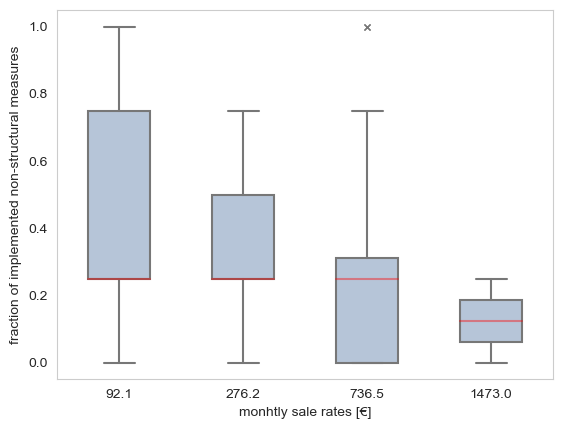

In [11]:
# plt.scatter(df_hcmc_d.shp_avgmonthly_sale_euro, df_hcmc_d.precautionary_measures_lowcost)
# plt.grid(b=None)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.boxplot(data=df_hcmc_d,
            x="shp_avgmonthly_sale_euro", 
            y="precautionary_measures_lowcost",
            width=.5,
            color="lightsteelblue",
            flierprops={"marker": "x"},
            medianprops={"color": "r", "alpha": 0.4},
         )# linecolor="black", ax=ax)
plt.xlabel("monhtly sale rates [€]")
plt.ylabel("fraction of implemented non-structural measures")

## bage
## --> tendency newer bui have rather at least one stuructural meausre implemtned
## --> old bui (built in 80s or earlier) have rather none stuructural meausre and usualy also none or only one cheap meausre implemtned
## --> newer bui have usually one otr two cheap precautionary impl or even more cheap measures.

## sale rates
## shops and retialers tend to impl more cheap precuationary meausres (prob. to save their goods/products), still the variation in implmentation ratio is quite high - visualized by long box size for the 50% of shops  
## while services and the few production sites do rather less cheap precuationary , do at least the serices have less to safe

In [12]:

# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(seed)

# Define name of output figure with BN; used by bn_visualize
fig_name = f"bn_{target}"

# Define the variable names
# names_list = ["Target_relative_contentloss_euro", "water_depth_cm", "b_area"]# inundation_duration_h
## -> employees -> 
print(df_hcmc_d.columns)

names_list = [
    "Target_relative_contentloss_euro", "flowvelocity", 
    "shp_avgmonthly_sale_euro", "bage", #"precautionary_measures_lowcost"
    "water_depth_cm", "precautionary_measures_lowcost", #"b_area", "emergency_measures"
    "precautionary_measures_expensive", #"inundation_duration_h"
    ]

## bage -> prec : 
## old building:inhabitant have practice in effective flood-adaption measres for their bui. + newe buis might located in rather floodprone areas
## DONE check inund.map if newer buis are located more in floodprone areas -> might expl bage -> -rcloss = NOPE no visible relationship
## TODO which shp have highest sale rates? are these services or spec. shps? -> might expl sales -> - prec-cheap = services and production have highest sale rates (higher than shops/retailers)
## --> higher sale rates -> less cheap meausres mainly done services and production sites (shops/retailers tend to impl more cheap measures, have lower sale rates),
## TODO ask Niv: remove mthl sale rates from bred ds - due that incoporated ?
## TODO ask D: bage -> - rcloss (not explable that newer bui in more floodprone areas) , idea bui owner have more experience which measures help
## -> bred: How strongly was your monthly sale/ production reduced during the flood? 
## -> mth sales: What is your monthly sale in average?

## bage -> - sale rates, bage -> -rcloss 
## (only weak expalination: shp owner have no money to move into newer bui, older buis in less floodprone areas)
## but most buis were build 1990s-2000s

# # Select the columns to use in the NPBN
df_hcmc_bn = df_hcmc_d[names_list]
 
names = {k: i for i, k in enumerate(names_list)}

print("Using following features:", names)

Index(['Target_relative_contentloss_euro', 'shp_avgmonthly_sale_euro', 'bage',
       'flowvelocity', 'precautionary_measures_lowcost', 'water_depth_cm',
       'flood_experience', 'inundation_duration_h', 'emergency_measures',
       'precautionary_measures_expensive', 'resilience', 'b_area',
       'shp_employees', 'contaminations', 'shp_content_value_euro',
       'geometry'],
      dtype='object')
Using following features: {'Target_relative_contentloss_euro': 0, 'flowvelocity': 1, 'shp_avgmonthly_sale_euro': 2, 'bage': 3, 'water_depth_cm': 4, 'precautionary_measures_lowcost': 5, 'precautionary_measures_expensive': 6}


In [13]:
# Extract number of nodes from df_hcmc
N = df_hcmc_bn.shape[1]  # number of nodes == number of features + target
print(N)

# Defining the structure of the BN
parent_cell = [None]*N


# ### --- Schema kid_cell = parent_cells --- ###

## for OBM + OSM 
# parent_cell[0] = [1, 2] #,4,5,6,7,8,9,10]                                                 #   target (parents: all other features)
# parent_cell[1] = []  # wd
# parent_cell[2] = [] # barea
# # # parent_cell[3] = [] # emplyees or sales

## for Can THo
parent_cell[0] = [1, 2, 3, 4, 5, 6]                                            #   target (parents: all other features)
parent_cell[1] = []
parent_cell[2] = []
parent_cell[3] = []
parent_cell[4] = [1, 6]
parent_cell[5] = [2 ]
parent_cell[6] = []


## check conditional spearman correlations of features: eg. b_area (evtl as standalone feature)

## small buildage/area -> less capital, if owner: building age -> b area -> capital, if rent : capital-> building
## test change one arc --> eval model
## hint: start small BN with two var with most correlated feature (2 vars) --> 
## get highest coorelation values
## 3. hydro vars (check conditional correlation given the registed captial)

## if new var doesnt add anything to cond corr (change arc or rm var)

## stop until no imporvement ~ 5-6 nodes for target


parent_cell

7


[[1, 2, 3, 4, 5, 6], [], [], [], [1, 6], [2], []]

<Figure size 500x500 with 0 Axes>

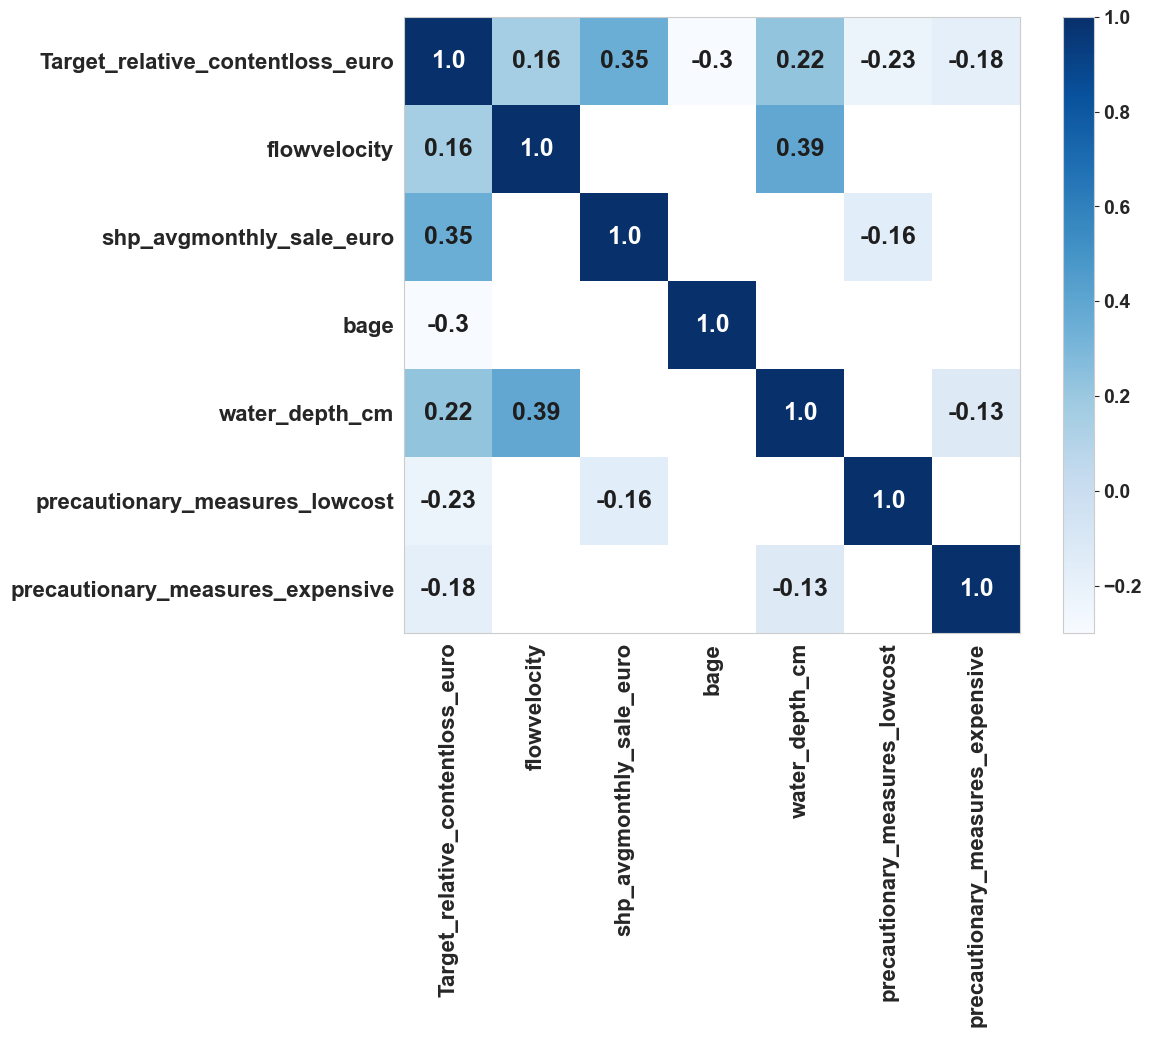

In [14]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

plt.figure(figsize=(5,5))
R = bn_rankcorr(parent_cell,        # structure of the BN
                df_hcmc_bn,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don"t create plot)

# The plot shows that target has the strongest correlation with water_barriers_impl,
# then the conditional correlation with flowveloctity (but maybe only due to strong correlation with water_depth and inundation_duration ). The conditional 
# correlations with with xx and xxx are weaker. Between other 
# variables, there is strong dependency between shp_registered_capital and shp_avg_monhtly_sale.



## Evaluation of degree of damage

In [15]:
# condition=[1, 2]
condition=[1, 2, 3, 4, 5, 6]

num_folds = 5
testset_size = int(len(df_hcmc_bn)/num_folds  // 1)

df_hcmc_d = df_hcmc_bn.sample(frac=1).reset_index(drop=True)  # reshuffle samples so that not all zero loss are in one fold
bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}
results = pd.DataFrame()


for i in range(num_folds):
    
    # ## split Fold into train and test
    test_nth_fold = df_hcmc_d[i*testset_size:][:testset_size] # 20% test
    train_nth_fold = df_hcmc_d[ ~df_hcmc_d.index.isin(test_nth_fold.index)] # 80% train
    # print(df_hcmc_d.shape , train_nth_fold.shape, test_nth_fold.shape)

    values = test_nth_fold.iloc[:,condition].to_numpy() 

    # derive rank correlations from training set of nth fold
    R = bn_rankcorr(parent_cell,        # structure of the BN
                train_nth_fold,
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = False)  

    # estimate loss on test set of nth fold
    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix 
                test_nth_fold,        
                Output="mean")    # type of output data, return averge of 
                #Output="median")    # type of output data
 
    ## predict target
    y_pred = F_test_nth_fold.squeeze()

    # observed target
    y_true = test_nth_fold.iloc[:,0].to_numpy()

    ## store for plotting obs ~ pred
    results_per_fold = pd.concat([pd.Series(y_true), pd.Series(y_pred).astype(int)], axis=1)
    results = pd.concat([results, results_per_fold], axis=0)

    # evaluation metrics
    MAE = eu.mean_absolute_error(y_true, y_pred)
    MBE = eu.mean_bias_error(y_true, y_pred)
    RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    # print(f"Scores from fold {i}:", MAE, MBE, RMSE, SMAPE) 
    # print(f"Inference - Uncertainty distribution, fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())



# print(y_pred, y_true)

results.columns = ["y_true", "y_pred"]

## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile = f"../../model_results/bn_performance_{target}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"Averaged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = f"../../model_results/bn_avg_performance_{target}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)

# 4 preds: 0  14.491298 -6.805579  17.791729  56.043545 

## pre_cheap
# no dep: 0  13.580885 -5.086162  17.560323  54.131192 
# sales -> pre: 0  12.576822 -3.864058  15.882124  53.329565 
# bage -> pre_cheap: weak corr < 0.10
# pre_cheap -> wd: weak corr < 0.10
# bage -> pre_exp: weak corr < 0.10 (same for sale rates)
# sale-> bage, (sale,bage) -> pre: 0  12.011064 -3.072826  15.944509  53.560565 
# precaution -0.0456 ** (no matter if pre-> wd or wd -> prec)

# median used for inference: 0  9.224541 -6.125418  18.073158  40.912663 
# mean used for inference: 0  13.089186 -3.005923  18.264466  55.655292 (inc fv)


Averaged evaluation scores of k-fold cross-validation (mean) :
         MAE       MBE     RMSE      SMAPE
0  11.88129  1.880703  17.1555  51.050483 
..saved to ../../model_results/bn_performance_Target_relative_contentloss_euro_hcmc.xlsx


### plot obs ~ pred

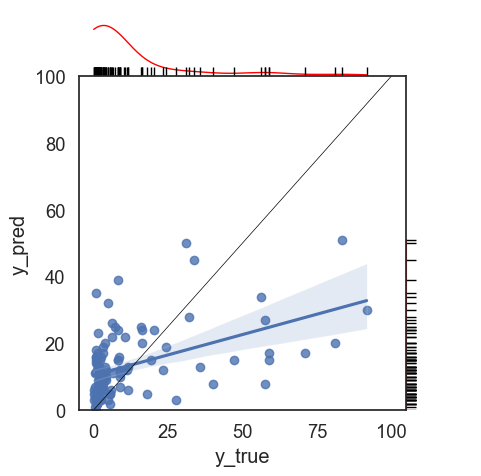

In [16]:
sns.set(style="white", font_scale=1.2)
g = sns.JointGrid(
    x=results["y_true"], y=results["y_pred"], 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 

g.plot_marginals(
    sns.distplot, color="black", #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={"color": "red", "cut": 0.0, "lw": 1},
)


g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
)
              
x0, x1 = (0, 100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

## Bn degree: 
- can capture very small loss ratios (over estimates them)
- regronize higher losses ratios as such but still under estimates them strongly
- 5-fold ccv: 0  11.888496 -1.900096  17.141786  51.108436 


In [17]:
# bins = np.linspace(0, 100, 100)

# plt.hist(results["y_true"], bins, alpha=0.7, label="empirical")
# plt.hist(results["y_pred"], bins, alpha=0.7, label="predicted")
# plt.legend(loc="upper right")
# plt.title("Target distributions for degree of loss for HCMC")
# plt.xlim(0,100)
# plt.show()


In [18]:
print(results.describe())


           y_true      y_pred
count  110.000000  110.000000
mean    11.995481   13.381818
std     19.578592   10.044837
min      0.101560    0.000000
25%      1.336940    6.000000
50%      3.432381   11.500000
75%     10.586663   17.000000
max     91.672324   51.000000


#### TODOS : 
- df_cantho_bn.b_area.describe() # TODO reduce bare cantho to 850 sqm 
    --> exploe maybe only drop largest business= NOPE, 
    --> check similiarty index between Cantho ~ hcmc
- fix names for y_true and y_pred for HCMC /cantho for degree loss and rcloss - cantho_y_true_pred_rcloss

# Rcloss estimation

Predict chance and degree of loss on holdout set of HCMC, which was kept unseen from ML and BN models


In [19]:
# df_hcmc_Xy =  df_hcmc.dropna().drop(["geometry", target], axis=1)  # drop incomplete records and geom col, needed for Logistic Regression model
# df_hcmc_y = df_hcmc_Xy[target] 
# df_hcmc_X = df_hcmc_Xy[["inundation_duration_h",
#        "water_depth_cm", "flowvelocity", "contaminations", "flood_experience",
#        "bage", "b_area", "emergency_measures",
#        "precautionary_measures_lowcost", "precautionary_measures_expensive",
#        "shp_employees", "resilience", "shp_avgmonthly_sale_euro"]]  # get vars in same order as during fit


## get chance of loss - HCMC
get predicted probabilities from nested cv , these are the predictions done on the outer test sets

In [20]:
## load estimated probabilities for chance of loss from ncv
df_hcmc_c  = pd.read_excel(f"../model_results/selected_features/chance_of_loss/predictions_{target}.xlsx")
print(df_hcmc_c.shape)

##  update probability column in respect to y_pred, 
## currently zero-loss cases have also probability between 0.5 - 1.0 % --> should be 0.0 - 0.49 %: if ypred == 0 --> then proba should be 1.0 -> 0.0 ; 0.98 -> 0.02  [old proba -> new proba]
df_hcmc_c = eu.reverse_probability_scores(df_hcmc_c, "y_proba", ("y_pred", 0.0))
df_hcmc_c["y_proba"].describe()

## add chance of loss as column to results df
df_hcmc_pred_cd[f"chance_pred_proba"] =  df_hcmc_c["y_proba"]
df_hcmc_pred_cd[f"predicted chance of closs"] =  df_hcmc_c["y_pred"]
df_hcmc_pred_cd[pred_target] =  0.0

(294, 6)


In [21]:
df_hcmc_pred_cd

,Target_relative_contentloss_euro,shp_avgmonthly_sale_euro,bage,flowvelocity,precautionary_measures_lowcost,water_depth_cm,flood_experience,inundation_duration_h,emergency_measures,precautionary_measures_expensive,resilience,b_area,shp_employees,contaminations,shp_content_value_euro,geometry,chance_pred_proba,predicted chance of closs,pred_Target_relative_contentloss_euro
0,0.0,276.2,12.0,0.2,0.00,10,76,2.0,0.000000,0.0,5.000000,25.0,1,0,441.9,POINT EMPTY,0.388,0,0.0
1,0.0,276.2,0.0,0.2,0.00,15,76,2.0,0.000000,0.0,5.000000,21.0,1,1,441.9,POINT (106.6990667908692 10.796493095049405),0.390,0,0.0
2,0.0,92.1,21.0,0.2,0.75,2,76,1.0,0.000000,0.5,4.000000,50.0,1,0,8285.8,POINT (106.70080527790017 10.797540370705613),0.359,0,0.0
3,0.0,92.1,20.0,0.1,0.75,10,16,3.0,0.000000,0.0,5.000000,25.0,1,0,1215.2,POINT (106.70113583213717 10.797534729984251),0.306,0,0.0
4,0.0,92.1,20.0,0.3,0.25,5,16,3.0,0.000000,0.5,5.000000,80.0,1,1,8285.8,POINT (106.70003992972188 10.797443653167456),0.438,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,0.0,276.2,2.0,0.4,1.00,50,151,5.0,1.000000,0.5,1.666667,185.0,2,1,6886.4,POINT EMPTY,0.551,1,0.0
290,0.0,92.1,33.0,0.3,1.00,60,151,4.0,0.833333,0.0,4.666667,150.0,2,1,4124.5,POINT EMPTY,0.534,1,0.0
291,0.0,92.1,15.0,0.3,0.75,40,76,2.0,0.666667,0.0,4.000000,80.0,1,1,6886.4,POINT EMPTY,0.506,1,0.0
292,0.0,276.2,1.0,0.2,0.50,40,151,5.0,0.666667,0.0,2.000000,80.0,2,1,9206.4,POINT (106.69150683690447 10.66047886618251),0.456,0,0.0


In [22]:
df_hcmc_c_pred = df_hcmc_c["y_pred"]
df_hcmc_c_proba = df_hcmc_c["y_proba"]
df_hcmc_c_true = df_hcmc_c["y_true"]

print(f"Actual zero-loss: {len(np.where(df_hcmc_c_true == 0)[0])} \nActual damage: {df_hcmc_c_true[df_hcmc_c_true == 1.0].shape[0]} \n")
print(f"Predict as zero-loss: {len(np.where(df_hcmc_c_pred == 0)[0])} \nPredict as damage: {len(np.where(df_hcmc_c_pred == 1)[0])} ")


Actual zero-loss: 180 
Actual damage: 114 

Predict as zero-loss: 172 
Predict as damage: 122 


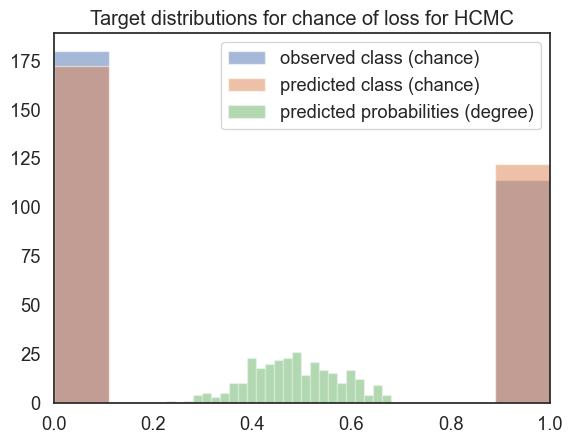

In [23]:
bins = np.linspace(0, 1, 10)


plt.hist(df_hcmc_c_true, bins, alpha=0.5, label="observed class (chance)")
plt.hist(df_hcmc_c_pred, bins, alpha=0.5, label="predicted class (chance)")
plt.hist(df_hcmc_c_proba, 25, alpha=0.3, label="predicted probabilities (degree)", color="green")
plt.legend(loc="upper right")
plt.title("Target distributions for chance of loss for HCMC")
plt.xlim(0,1)
plt.show()


## predict degree of loss - HCMC
### TODO mv to previous section of predict degree

In [24]:
df_hcmc_d.shape

(114, 7)

In [25]:
# condition=[1, 2]
condition=[1, 2, 3, 4 ,5,6]

## select only variables used in BN
df_hcmc_d = df_hcmc_bn[names_list]

num_folds = 3
testset_size = int( len(df_hcmc_d) / num_folds  // 1)

df_hcmc_d = df_hcmc_d.sample(frac=1).reset_index(drop=True)  # reshuffle samples so that not all zero loss are in one fold
bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}
degree_results = pd.DataFrame()  # store y_true and y_pred 


for i in range(num_folds):
    
    # ## split Fold into train and test
    test_nth_fold = df_hcmc_d[i*testset_size:][:testset_size] # 20% test
    train_nth_fold = df_hcmc_d[ ~df_hcmc_d.index.isin(test_nth_fold.index)] # 80% train
    # print(df_hcmc_d.shape , train_nth_fold.shape, test_nth_fold.shape)
    print(f"all samples and variables passed to CV: {df_hcmc_d.shape}, \ntraining and test samples for {i} fold: {train_nth_fold.shape[0], test_nth_fold.shape[0]}")

    values = test_nth_fold.iloc[:,condition].to_numpy() 

    # BN train on fold
    R = bn_rankcorr(parent_cell,        # structure of the BN
                train_nth_fold,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = False)  

    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix 
                test_nth_fold,        # DataFrame with df_hcmc
                Output="mean")    # type of output data
                #Output="median")    # type of output data
 
    ## predict target
    y_pred = F_test_nth_fold.squeeze()

    # Fill out the column(s) which are predicted
    y_true = test_nth_fold.loc[:,target].to_numpy()

    ## store for plotting obs ~ pred
    results_per_fold = pd.concat([pd.Series(y_true).round(2), pd.Series(y_pred).round(2)], axis=1)
    degree_results = pd.concat([degree_results, results_per_fold], axis=0)

    # evaluation metrics
    MAE = eu.mean_absolute_error(y_true, y_pred)
    MBE = eu.mean_bias_error(y_true, y_pred)
    RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    print(f"Scores from fold {i}:", MAE, MBE, RMSE, SMAPE) 
    print(f"Inference - Uncertainty distribution, fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())



# print(y_pred, y_true)

degree_results.columns = ["y_true", "y_pred"]

## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile = f"../../model_results/bn_performance_{target}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"Averaged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = f"../../model_results/bn_avg_performance_{target}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)




# median used for inference: 0  9.224541 -6.125418  18.073158  40.912663 
# mean used for inference: 0  13.089186 -3.005923  18.264466  55.655292 (inc fv)


all samples and variables passed to CV: (114, 7), 
training and test samples for 0 fold: (76, 38)
Scores from fold 0: 12.508310194366477 2.2946440450729804 18.913434340456305 55.83374949848043
Inference - Uncertainty distribution, fold 0:  count    38.000000
mean     12.356039
std       9.332616
min       1.136312
25%       4.905228
50%      10.625335
75%      15.685970
max      38.291267
dtype: float64
all samples and variables passed to CV: (114, 7), 
training and test samples for 1 fold: (76, 38)
Scores from fold 1: 13.079106000155697 3.153185136638427 18.092002709525364 50.61300997702672
Inference - Uncertainty distribution, fold 1:  count    38.000000
mean     16.464642
std      11.389971
min       1.263911
25%       7.907940
50%      14.492115
75%      20.881395
max      53.446005
dtype: float64
all samples and variables passed to CV: (114, 7), 
training and test samples for 2 fold: (76, 38)
Scores from fold 2: 9.21397705412989 -0.6434303954622191 12.513434603084404 46.8929695931

In [26]:
# #-----------------------------------------------------------------------------
# # Function 2 - bn_visualize - Plot of the Bayesian Network
# #-----------------------------------------------------------------------------

# """BN structure with graph + rank correlations on degree of loss samples"""

# fig_name = f"bn_{target}"

# print(df_hcmc_d.columns)

# df_hcmc_d_plot = df_hcmc_d.rename(
#     columns={
#         "shp_avgmonthly_sale_euro": "mthly_sale_rates",
#         #"precautionary_measures_expensive": "structural_measures",
#         "flowvelocity" : "flow_velocity",
#         "water_depth_cm": "water_depth",
#         "bage": "building_age",
#         "Target_relative_contentloss_euro" : "rcloss",
#         "precautionary_measures_lowcost": "non-strucural_measures", 
#         "precautionary_measures_expensive": "strucural_measures"

#     })


# R = bn_rankcorr(parent_cell,        # structure of the BN
#             df_hcmc_d_plot,   # matrix of df_hcmc
#             var_names = names,  # names of variables
#             is_data = True,        # matrix data contains actual data
#             plot = True) 

# bn_visualize(parent_cell,           # structure of the BN
#              R,                     # the rank correlation matrix (function 1)
#              df_hcmc_d_plot.columns,          # names of variables
#              fig_name = fig_name)   # figure name
# # The plot presents the BN with x nodes and x arcs, with the (conditional)
# # rank correlations indicated on the arcs.

# bn_visualize(parent_cell,                       # structure of the BN
#              R,                                 # the rank correlation matrix 
#              df_hcmc_d_plot.columns,                      # names of variables
#              data = df_hcmc_d_plot,                       # DataFrame with data
#              fig_name = fig_name + "_margins")  # figure name
# # The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# # rank correlations indicated on the arcs. In this plot also the marginal
# # distributions for each variable are incorporated.


In [27]:
print(len(np.where(df_hcmc_incl_zero.dropna()[target] > 0.0)[0]) ) # all observed damage-cases in HMCC

114


In [28]:
# import matplotlib.pyplot as plt
# import mpl_scatter_density # adds projection="scatter_density"
# from matplotlib.colors import LinearSegmentedColormap

# # "Viridis-like" colormap with white background
# white_viridis = LinearSegmentedColormap.from_list("white_viridis", [
#     (0, "#ffffff"),
#     (1e-20, "#440053"),
#     (0.2, "#404388"),
#     (0.4, "#2a788e"),
#     (0.6, "#21a784"),
#     (0.8, "#78d151"),
#     (1, "#fde624"),
# ], N=20)# N=256)

In [29]:
# ## Code snippet: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density

# import mpl_scatter_density # adds projection="scatter_density"
# from matplotlib.colors import LinearSegmentedColormap

# # "Viridis-like" colormap with white background
# white_viridis = LinearSegmentedColormap.from_list("white_viridis", [
#     (0, "#ffffff"),
#     (1e-20, "#440053"),
#     (0.2, "#404388"),
#     (0.4, "#2a788e"),
#     (0.6, "#21a784"),
#     (0.8, "#78d151"),
#     (1, "#fde624"),
# ], N=20)# N=256)

# def using_mpl_scatter_density(fig, x, y):
#     ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
#     density = ax.scatter_density(
#         x=degree_results["y_true"], y=degree_results["y_pred"], 
#         cmap=white_viridis
#     )
#     fig.colorbar(density, label="Number of points per pixel")

# fig = plt.figure()
# using_mpl_scatter_density(fig, degree_results["y_true"], y=degree_results["y_pred"])
# plt.show()

In [30]:
# bins = np.linspace(0, 100, 100)

# plt.hist((pd.Series(bn_y_true.astype(int))), bins, alpha=0.5, label="empirical")
# plt.hist((pd.Series(bn_y_pred.astype(int))), bins, alpha=0.5, label="predicted")
# plt.legend(loc="upper right")
# plt.title("Target distributions for HCMC  - only predicted as degree of loss(empirical and predicted)")
# plt.show()


In [31]:
degree_results["y_pred"].describe()

count    114.000000
mean      13.553421
std        9.991036
min        1.140000
25%        6.257500
50%       11.435000
75%       18.497500
max       53.450000
Name: y_pred, dtype: float64

## get relative content loss estimations (chance * degree of loss)

In [32]:
## index of damage cases
idx_damage = np.where(df_hcmc_incl_zero[target] > 0.0)[0]
# idx_damage = np.where(df_cantho_c_y == 1)[0]

print("sample number of damage cases returned from CV should equal the number of original damage cases:", 
      len(idx_damage), len(degree_results["y_pred"]))  
# != len(idx_damage) -> change fold number in CV bc some sample were dropped bc same samples were not used in CV for train/test

## new col incl prediction of degree of loss, all non-damage cases are set as 0 
# df_hcmc_pred_cd.reset_index(drop=True, inplace=True)
df_hcmc_pred_cd[pred_target] =  0.0   # new col for rcloss predictions
df_hcmc_pred_cd[pred_target].iloc[idx_damage] = degree_results["y_pred"]
#df_hcmc_pred_cd.loc[idx_damage, pred_target] = degree_results["y_pred"]

df_hcmc_pred_cd["degree_pred"] = np.nan
df_hcmc_pred_cd["degree_pred"].iloc[idx_damage] = degree_results["y_pred"] # new col for degree of loss predictions from BN,  only for evaluation if damage-cases were assigned correctly
#df_hcmc_pred_cd.loc[idx_damage, "degree_pred"] = degree_results["y_pred"] # TODO check why not possible -> dublicate labels <- solve this
df_hcmc_pred_cd["degree_pred"].describe()

sample number of damage cases returned from CV should equal the number of original damage cases: 114 114


count    114.000000
mean      13.553421
std        9.991036
min        1.140000
25%        6.257500
50%       11.435000
75%       18.497500
max       53.450000
Name: degree_pred, dtype: float64

In [33]:
# ## bn_degree_true_pred  # degree of damages
# ## y_cantho_proba_damage # chance that instance is a damage-case


# ## get estimation of relative content loss
# # y_pred_rcloss = df_hcmc_pred_cd[pred_target] * df_hcmc_c["y_proba"].reset_index(drop=True)  # risk = damage [0,100] * percent point [0,1]
# # y_pred_rcloss = bn_degree_true_pred["y_pred"] * y_hcmc_chance_proba[0].reset_index(drop=True)  # risk = damage [0,100] * percent point [0,1]
# ## add zero-loss cases
# y_pred_rcloss = y_pred_rcloss.fillna(0.0)
# y_pred_rcloss


## get estimation of relative content loss
df_hcmc_pred_cd[pred_target] = df_hcmc_pred_cd[pred_target] * df_hcmc_pred_cd[f"chance_pred_proba"]  # risk = damage [%] * chance [0,1]
df_hcmc_pred_cd[pred_target].describe()

print(df_hcmc_pred_cd.columns)
df_hcmc_pred_cd[[target, pred_target, "degree_pred", f"chance_pred_proba"]].describe()

Index(['Target_relative_contentloss_euro', 'shp_avgmonthly_sale_euro', 'bage',
       'flowvelocity', 'precautionary_measures_lowcost', 'water_depth_cm',
       'flood_experience', 'inundation_duration_h', 'emergency_measures',
       'precautionary_measures_expensive', 'resilience', 'b_area',
       'shp_employees', 'contaminations', 'shp_content_value_euro', 'geometry',
       'chance_pred_proba', 'predicted chance of closs',
       'pred_Target_relative_contentloss_euro', 'degree_pred'],
      dtype='object')


,Target_relative_contentloss_euro,pred_Target_relative_contentloss_euro,degree_pred,chance_pred_proba
count,294.000000,294.000000,114.000000,294.000000
mean,4.634567,2.588000,13.553421,0.484306
std,13.369524,4.572610,9.991036,0.089973
min,0.000000,0.000000,1.140000,0.226000
25%,0.000000,0.000000,6.257500,0.419250
50%,0.000000,0.000000,11.435000,0.484000
75%,1.956288,4.079397,18.497500,0.551750
max,91.672324,27.109190,53.450000,0.680000


# Evaluation of rcloss estimations - HCMC

In [34]:
rcloss_true = df_hcmc_pred_cd[target]
rcloss_pred = df_hcmc_pred_cd[pred_target]

# evaluation metrics
MAE = eu.mean_absolute_error(rcloss_true, rcloss_pred).round(3)
MBE = eu.mean_bias_error(rcloss_true, rcloss_pred).round(3)
RMSE = eu.root_mean_squared_error(rcloss_true, rcloss_pred).round(3) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(rcloss_true, rcloss_pred).round(3)


print(f"MAE: {MAE}, \nMBE: {MBE}, \nRMSE: {RMSE}, \nSMAPE: {SMAPE}")  

eu.empirical_vs_predicted(rcloss_true, rcloss_pred)

MAE: 4.268, 
MBE: -2.047, 
RMSE: 12.284, 
SMAPE: 19.484


,nobs,median,mean,min max,variance,standard deviation,coef variation
empirical,294,0.0,4.452381,"[0, 91]",175.74,13.23,297.741131
predicted,294,0.0,2.401361,"[0, 27]",19.51,4.41,183.941287


### Plot obs ~ pred


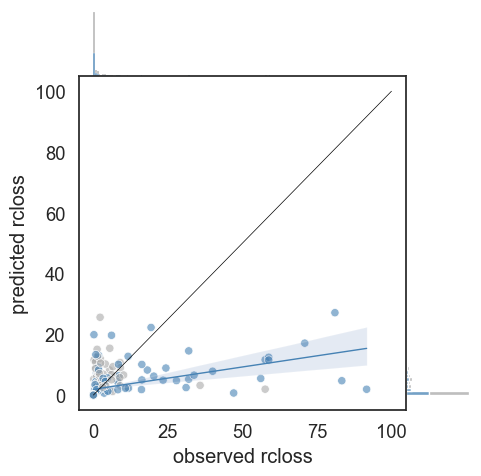

In [35]:
f.plot_observed_predicted(
    y_true=rcloss_true, y_pred=rcloss_pred, 
    hue=df_hcmc_pred_cd["predicted chance of closs"],
    xlabel=f"observed {target_plot}", ylabel=f"predicted {target_plot}",
    legend=False ,#True
    outfile=rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\figures\scatter_obs_pred_{target_plot}_hcmc.png"
)     


### Main validation results

In [36]:
# ## get damage ratio in respect to total number of cases
# c = "y_pred"
# print(len(np.where(rcloss_pred > 0.0)[0])) 
# print(len(np.where(rcloss_pred > 0.0)[0]) / len(rcloss_true) * 100, "%")
# np.mean(rcloss_true)


## get ratio of damage cases vs total reported bred

c = rcloss_true
print(len(np.where(c > 0.0)[0])) 
print(len(np.where(c > 0.0)[0]) / len(c) * 100, "%")
np.mean(c)


114
38.775510204081634 %


4.634567254402192

In [37]:
results_hcmc = pd.DataFrame(
            {
                "y_true": rcloss_true,
                "y_pred": rcloss_pred,
                "residual": rcloss_true - rcloss_pred,
            },
            index=rcloss_true.index,
        )
print(results_hcmc.describe())


for c in results_hcmc.columns:
    ci = eu.calc_confidence_interval(results_hcmc[c], confidence_level=0.95)

eu.empirical_vs_predicted(rcloss_true, rcloss_pred)

           y_true      y_pred    residual
count  294.000000  294.000000  294.000000
mean     4.634567    2.588000    2.046568
std     13.369524    4.572610   12.132531
min      0.000000    0.000000  -23.359569
25%      0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000
75%      1.956288    4.079397    0.000000
max     91.672324   27.109190   89.766294
confidence interval: (3.099992740265052, 6.169141768539333) 
cases within interval: 22
confidence interval: (2.063148374126937, 3.112850741519322) 
cases within interval: 13
confidence interval: (0.6539771466454292, 3.4391582465126973) 
cases within interval: 10


,nobs,median,mean,min max,variance,standard deviation,coef variation
empirical,294,0.0,4.452381,"[0, 91]",175.74,13.23,297.741131
predicted,294,0.0,2.401361,"[0, 27]",19.51,4.41,183.941287


### Absolute degree of content loss

In [39]:
##  get first abs loss of only damage cases (only BN results) due that rcloss cases are all multiplied by chance of loss
df_hcmc_acloss = df_hcmc_pred_cd.copy()
df_hcmc_acloss["acloss_true"] = df_hcmc_acloss[target] *  df_hcmc_acloss["shp_content_value_euro"] / 100
## NOTE use here vulnerability rcloss (BN*chance)
# df_cantho_acloss["abs_degree_pred"] = df_cantho_acloss[pred_target] *  df_cantho_acloss["shp_content_value_euro"] / 100 
## NOTE use here BN result (degree of loss)
df_hcmc_acloss["abs_degree_pred"] = df_hcmc_acloss["degree_pred"] *  df_hcmc_acloss["shp_content_value_euro"] / 100 
print("abs_degree_pred has no zero-loss cases (min=", round(df_hcmc_acloss["abs_degree_pred"].min(),2), ") and", df_hcmc_acloss.shape[0],"damage cases")


## keep only damage cases to calc abs. degree of loss
print("check that osberved and predicted damage cases have the same index and can be therefore clipped by the index of one of both variables")
assert df_hcmc_acloss.acloss_true[df_hcmc_acloss["acloss_true"] > 0.0].index.all() == df_hcmc_acloss.abs_degree_pred[df_hcmc_acloss["abs_degree_pred"] > 0.0].index.all(), "not same idx in obs and pred degree of loss"

df_hcmc_adegree = pd.DataFrame(columns=["abs_degree_true", "abs_degree_pred"]).reset_index(drop=True)
df_hcmc_adegree["abs_degree_true"] = df_hcmc_acloss["acloss_true"][df_hcmc_acloss["acloss_true"] > 0.0]
df_hcmc_adegree["abs_degree_pred"] = df_hcmc_acloss["abs_degree_pred"][df_hcmc_acloss["acloss_true"] > 0.0]  # remove all np.nan in "abs_degree_pred" (these are the zero-loss cases) by using idx from obs. zero-loss



## add dummy binary var for plotting
df_hcmc_adegree["abs_degree_true_dummy"] =  1.0   


print("HCMC : absolute degree of content loss (only damage cases)")
eu.empirical_vs_predicted(df_hcmc_adegree["abs_degree_true"], df_hcmc_adegree["abs_degree_pred"])

## HCMC abs degree of loss
# #	       nobs	median	mean	    min max	   variance	standard deviation	coef variation
# empirical	114	117.0	352.517544	[7, 3618]	347977.77	587.30	        167.338171
# predicted	114	352.5	575.140351	[19, 6483]	812338.46	897.34	        156.709263

abs_degree_pred has no zero-loss cases (min= 15.53 ) and 294 damage cases
check that osberved and predicted damage cases have the same index and can be therefore clipped by the index of one of both variables
HCMC : absolute degree of content loss (only damage cases)


,nobs,median,mean,min max,variance,standard deviation,coef variation
empirical,114,117.0,352.517544,"[7, 3618]",347977.77,587.30,167.338171
predicted,114,384.0,594.640351,"[15, 3373]",381336.06,614.81,103.848340


NOtes to  abs loss
- obs and pred mean are quite similar, underestimate higher losses

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from matplotlib.cbook import boxplot_stats  
from matplotlib.colors import to_rgba

def plot_observed_predicted_abs(y_true, y_pred, hue, hue_colors=("darkgrey","steelblue"), xlabel="observed", ylabel="predicted", alpha=0.6, legend=False, outfile="test.png"):
    """
    Scatter plot of observations vs predictions with optional class colors
    NOTE: hue is currently limited to binary cases
    # Code Snippet: https://stackoverflow.com/questions/66667334/python-seaborn-alpha-by-hue
    """

    sns.set(style="white", font_scale=1.2)

    color_dict = {
        0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
        1: to_rgba(hue_colors[1], alpha)
    }
    
    g = sns.JointGrid(
        x=y_true, y=y_pred, hue=hue,
        height=5, space=0,)
    # g.plot_joint(sns.scatterplot, palette=color_dict, edgecolors=color_dict, legend=legend)
    p = sns.scatterplot(
        x=y_true, y=y_pred, hue=hue, 
        palette=color_dict, edgecolors=color_dict, legend=legend, 
        ax=g.ax_joint)
    
    if legend is True:
        #p.legend(fontsize=10, )  # outside plot: bbox_to_anchor= (1.2,1)
        plt.setp(p.get_legend().get_texts(), fontsize='12')  
        plt.setp(p.get_legend().get_title(), fontsize='15')

    g.plot_marginals(sns.histplot, kde=False, palette=color_dict, multiple='stack')

    g1 = sns.regplot(
        x=y_true, y=y_pred, 
        line_kws={"lw":1.},
        scatter=False, ax=g.ax_joint)
    regline = g1.get_lines()[0]
    regline.set_color('steelblue')

    x0, x1 = (0, 100) 
    y0, y1 = (0, 100)
    lims = [min(x0, y0), max(x1, y1)]
    g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)

    # save plot
    plt.savefig( outfile, dpi=300, bbox_inches="tight")

    plt.show()
   # plt.close()


In [41]:
# 	nobs	median	mean	min max	variance	standard deviation	coef variation
# empirical	114	117.0	352.517544	[7, 3618]	347977.77	587.30	167.338171
# predicted	114	11.0	13.070175	[1, 53]	100.53	9.98	76.711027

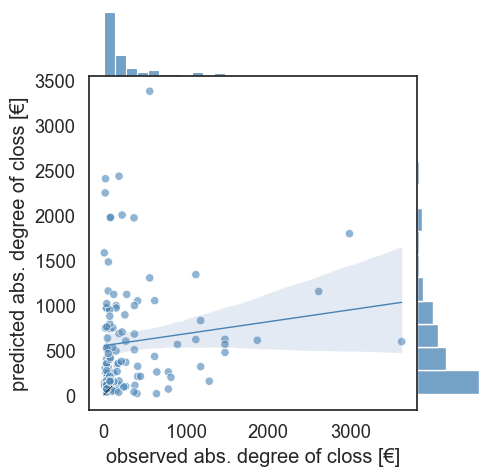

In [42]:
## TODO adapt x and y aixs to same limits -> use fixed max for xlim and ylim 
plot_observed_predicted_abs(
    y_true=df_hcmc_adegree["abs_degree_true"], y_pred=df_hcmc_adegree["abs_degree_pred"], 
    hue=df_hcmc_adegree["abs_degree_true_dummy"],
    xlabel=f"observed abs. degree of closs [€]", ylabel=f"predicted abs. degree of closs [€]",
    legend=False ,#True
    outfile=rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\figures\scatter_obs_pred_abs_degree_{target_plot}_hcmc.png"
)     


In [43]:


# # ### Plot prediction error from outer cv
# f.plot_results(
#     results=predicted_values, 
#     model_names_abbreviation=["cforest", "ElasticNet", "XGBRegressor"],  
#     model_names_plot=["Conditional Random Forest", "Elastic Net", "XGBoost"],
#     outfile=f"../../model_results/models_evaluation/degree_of_loss/results_{target}.png"
# )


In [44]:
# bins = np.linspace(0, 100, 100)
# plt.hist(df_hcmc_bn[target], bins, alpha=0.5, label="hcmc rcloss")
# plt.hist(df_cantho[target], bins, alpha=0.5, label="cantho rcloss")
# plt.legend(loc="upper right")
# plt.title("Target distributions for both cities (empirical)")
# plt.show()


### BN visualize - distributions

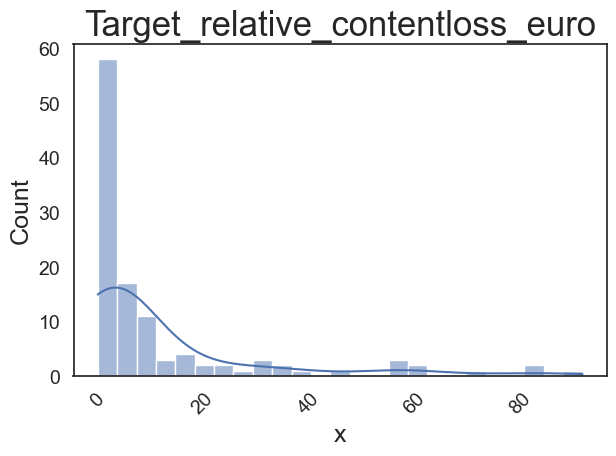

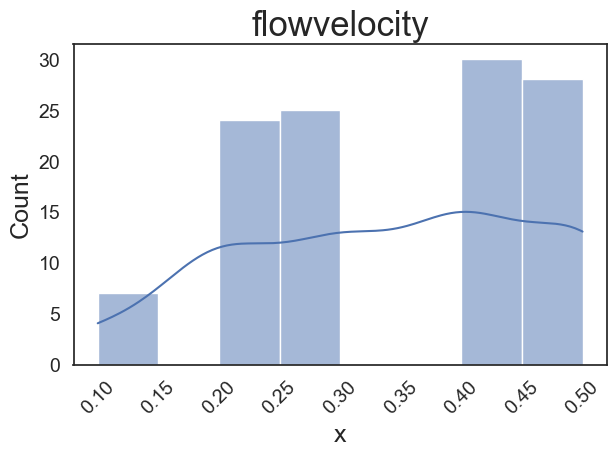

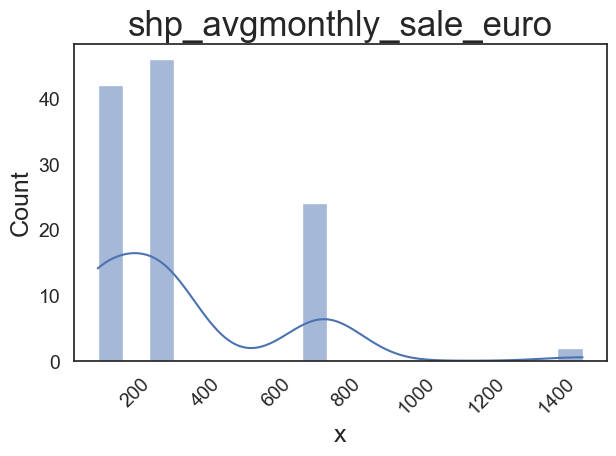

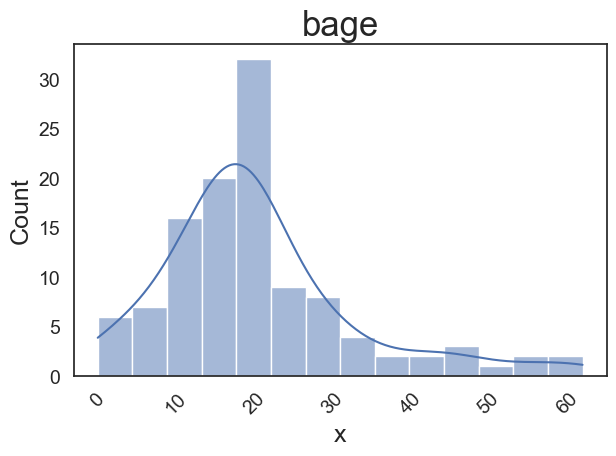

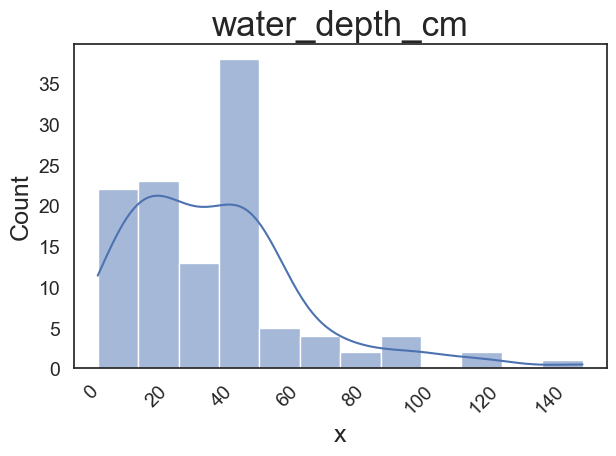

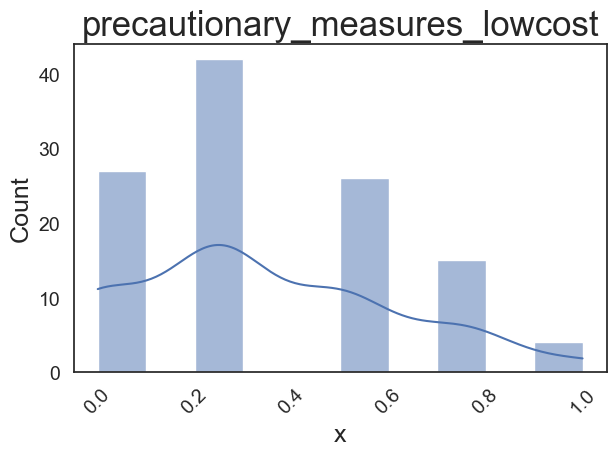

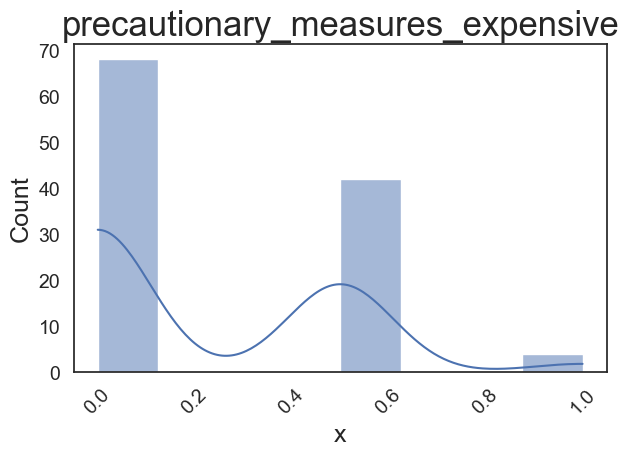

'BN plot saved in : c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\bayesian_networks\\BN_visualize_bn_Target_relative_contentloss_euro_margins.pdf'

In [45]:
#-----------------------------------------------------------------------------
# Function 2 - bn_visualize - Plot of the Bayesian Network
#-----------------------------------------------------------------------------

bn_visualize(parent_cell,           # structure of the BN
             R,                     # the rank correlation matrix (function 1)
             df_hcmc_bn.columns,          # names of variables
             fig_name = fig_name)   # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs.

bn_visualize(parent_cell,                       # structure of the BN
             R,                                 # the rank correlation matrix 
             df_hcmc_bn.columns,                      # names of variables
             data = df_hcmc_bn,                       # DataFrame with data
             fig_name = fig_name + "_margins")  # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs. In this plot also the marginal
# distributions for each variable are incorporated.


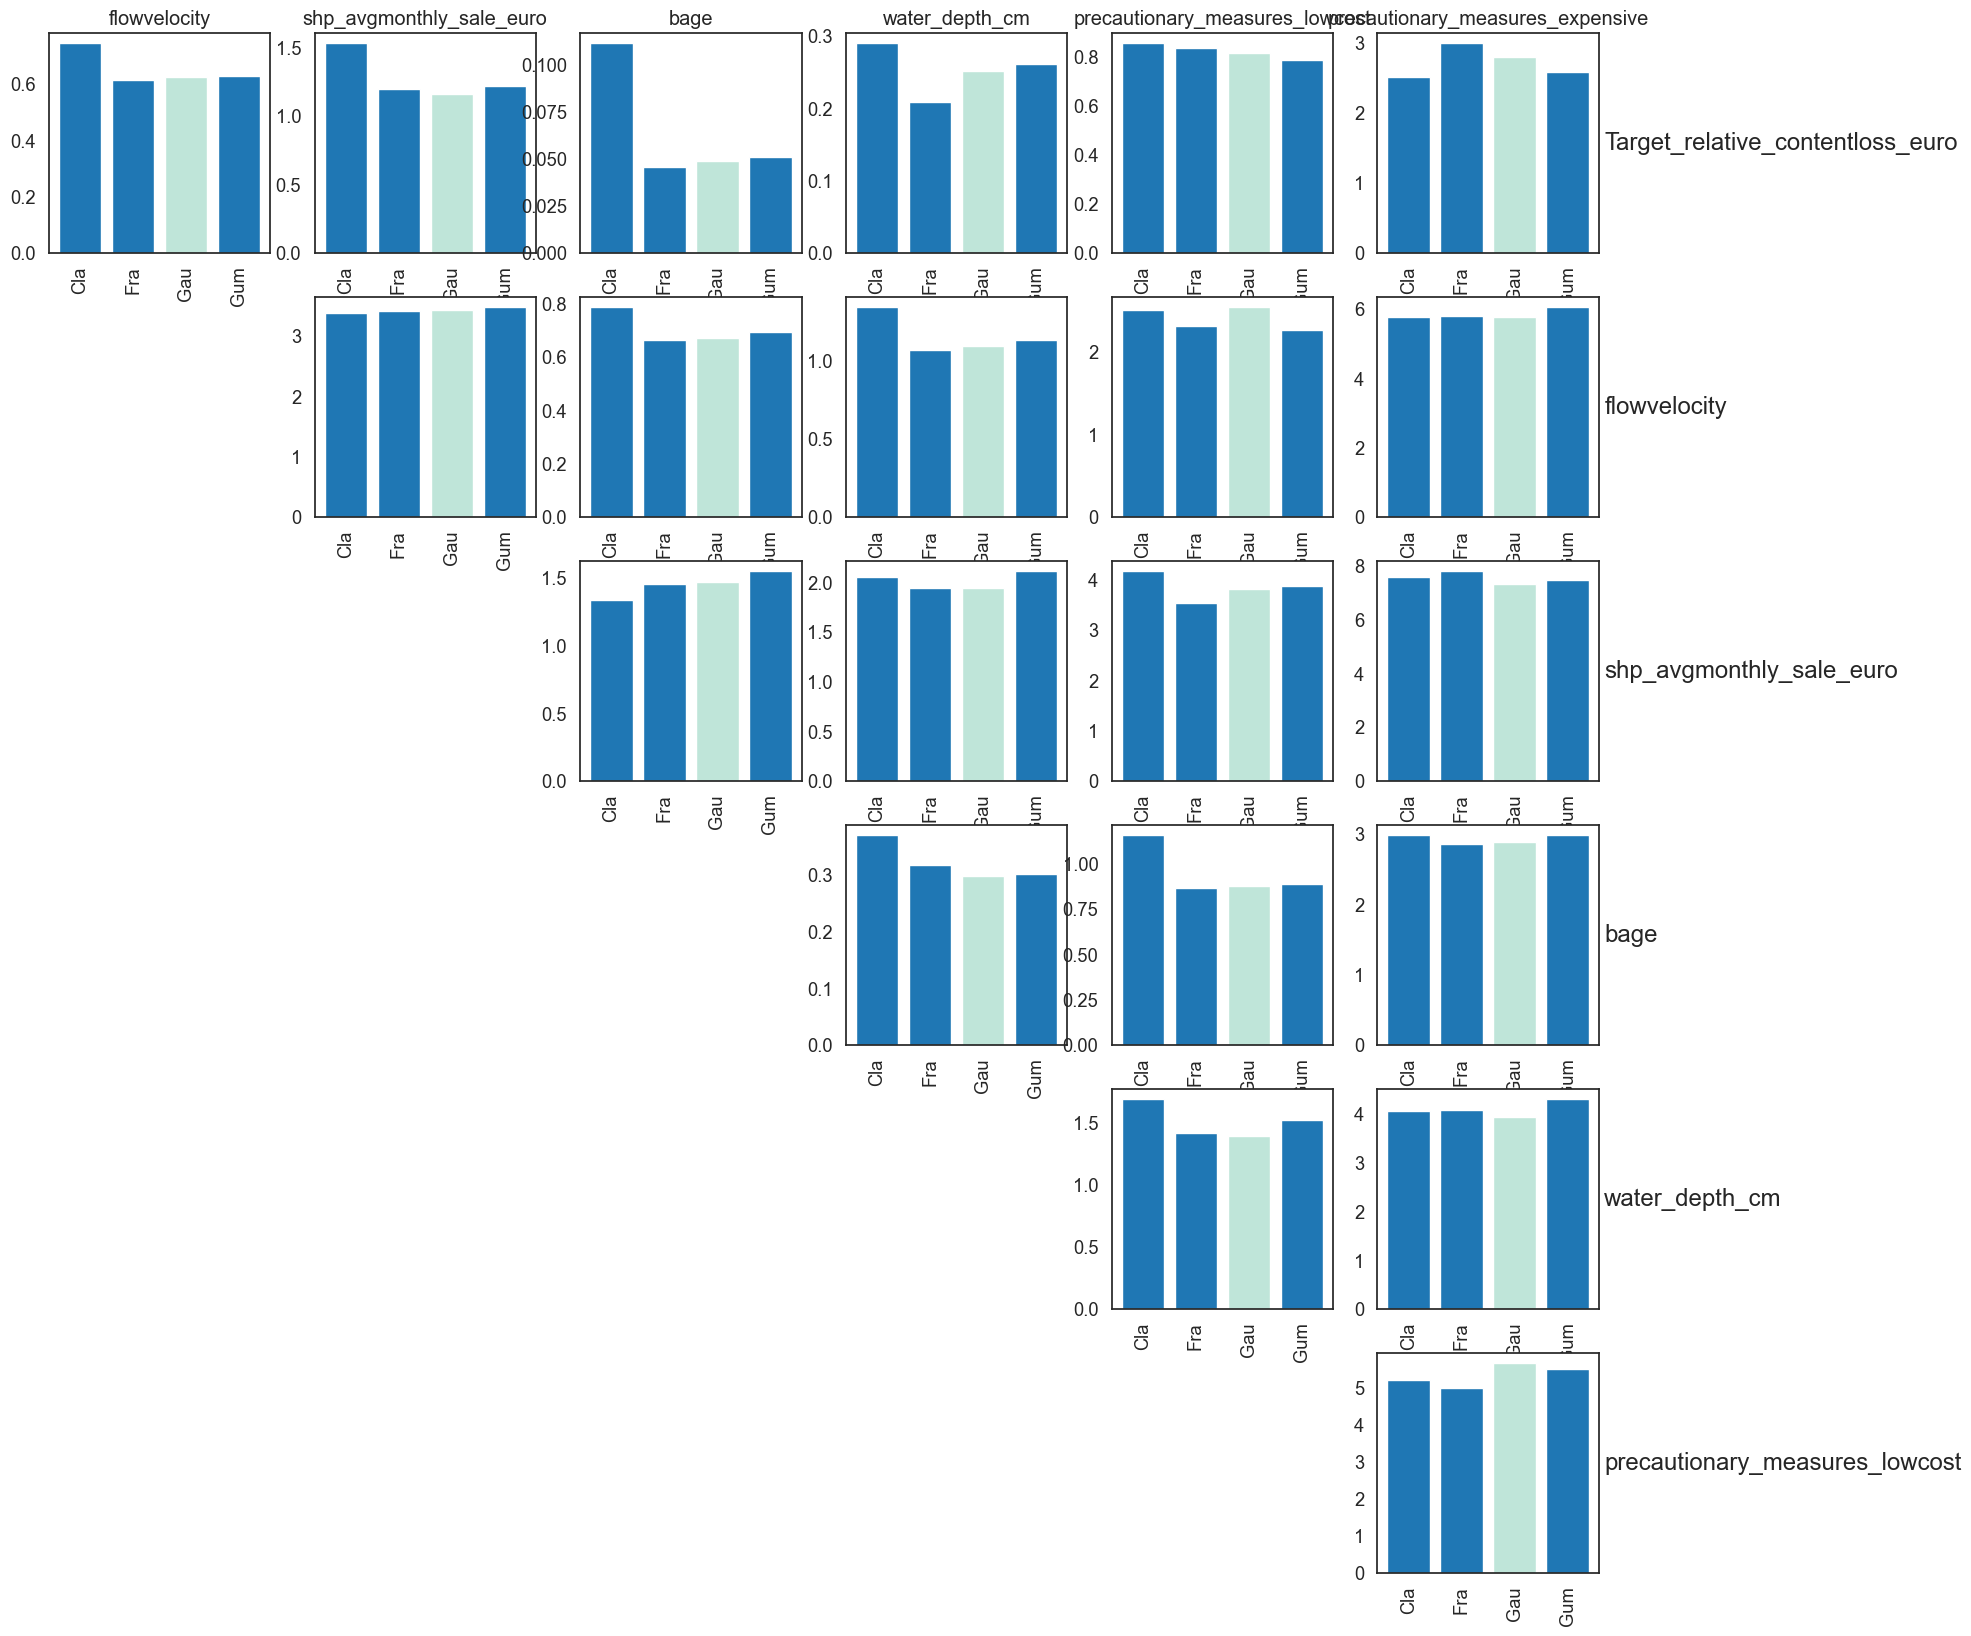

In [46]:
#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------

M = cvm_statistic(df_hcmc_bn,                   # df_predictorsFrame with df_hcmc
                  names = df_hcmc_bn.columns,   # names of variables
                  plot = True,               # create a plot (0=don"t create plot)
                  fig_name = fig_name)    # figure name
                  
# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.


## !! decalibration score = overall score if BN fullfills 

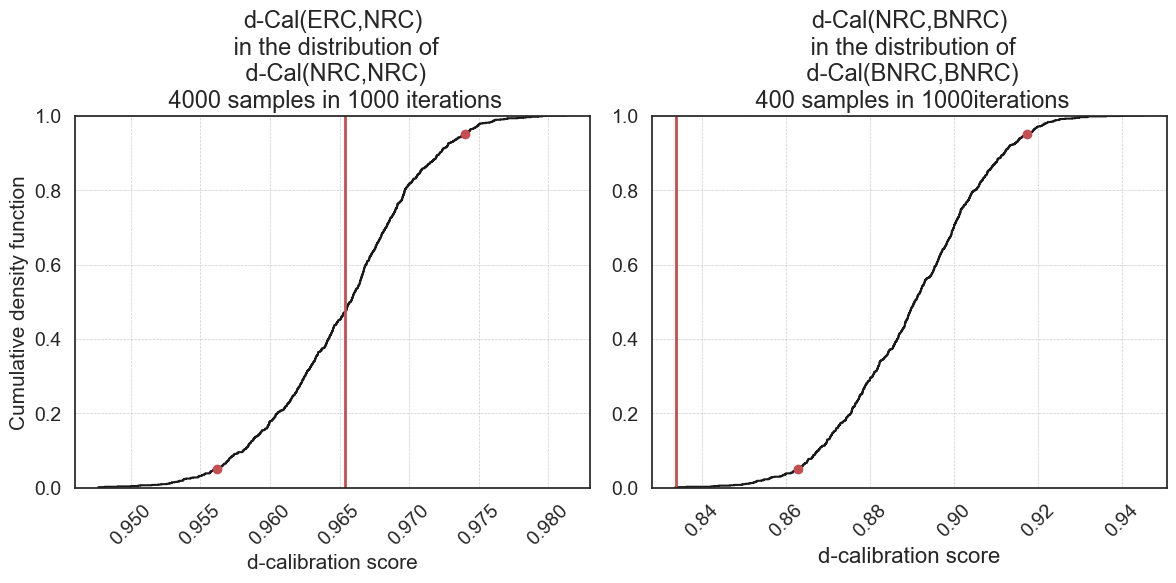

SUCCESS: The d-Cal of the empirical rank correlation matrix (ERC) fall between the confidence intervals of the d-Cal of the normal rank correlation matrix (NRC)

FAILURE: The d-Cal of the normal rank correlation matrix (NRC) is out of the confidence intervals of the d-Cal of the BN rank correlation matrix (BNRC)



In [47]:
#-----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
#-----------------------------------------------------------------------------

## TODO fix np.mul() --> fixed with np.mulitply() in d_cal.py from py_banshee package ~ 1h
## try to fix, otherwise write with CC Dominik (maybe mixed up respective matlab func()--> )

# gaussian_distance : validation: 
D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
                            R,        # the rank correlation matrix 
                            df_hcmc_bn,     # df_predictorsFrame with df_hcmc
                            4000,     # number of samples drawn d-Cal(ERC,NRC)
                            400,      # number of samples drawn d-Cal(NRC,BNRC)
                            1000,     # number of iterations to compute CI
                            Plot=True,          # create a plot (0=don"t create plot)
                            Type="H",           # take Hellinger distance (default)
                            fig_name=fig_name)  # figure name

                        
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the empirical rank correlation matrix is
# inside the 90# confidence interval of the determinant of the empirical
# The d-calibration score of the BN"s rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large df_predictorssets.


# Model transferability
Test trained NPBN for CanTHo DS

In [48]:
## load cantho predictors
infile_name = "input_data_contentloss_cantho"
df_cantho_incl_zero = pd.read_excel(f"../input_survey_data/{infile_name}.xlsx")

df_cantho_incl_zero = df_cantho_incl_zero.dropna()  # ML cant predict on incomplete records
print(df_cantho_incl_zero[target].describe())

## load classifier for chance of loss
clf_file = "LogisticRegression_Target_relative_contentloss_euro"
# clf_file = "RandomForestClassifier_Target_relative_contentloss_euro"
clf_filepath = rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\model_results\models_trained\chance_of_loss\final_models\{clf_file}.joblib"
clf = load(clf_filepath) 
clf


count    283.000000
mean       9.326177
std       17.625553
min        0.000000
25%        0.000000
50%        0.000000
75%        9.600492
max       92.950717
Name: Target_relative_contentloss_euro, dtype: float64


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=3, l1_ratio=0.75, max_iter=50,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga', tol=1e-05))])

In [49]:
## binary cases for chance of loss 
df_cantho_c = df_cantho_incl_zero.copy()
df_cantho_c.drop("shp_content_value_euro", axis=1, inplace=True) # drop content value due only needed for abs. los calcualtion
df_cantho_c[target][df_cantho_c[target] > 0] = 1 ## set target as binary class
df_cantho_c_X = df_cantho_c.drop(target, axis=1)
df_cantho_c_y = df_cantho_c[target]
print("Cases to predict chance of loss:", df_cantho_c_X.shape[0])

## damage cases of CanTHo used to predict on
df_cantho_d = df_cantho_incl_zero.loc[df_cantho_incl_zero[target]>0.0, :]  # extract damage cases (loss >0.0)
df_cantho_d_X = df_cantho_d.drop(target, axis=1)
df_cantho_d_y = df_cantho_d[target]
print("Damage cases to predict degree of loss:", df_cantho_d_X.shape[0])

Cases to predict chance of loss: 283
Damage cases to predict degree of loss: 138


In [50]:
df_cantho_d.describe()

,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,shp_employees,resilience,shp_content_value_euro,shp_avgmonthly_sale_euro
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,19.125421,3.818841,26.188406,0.467391,0.717391,45.608696,4.550725,92.707971,0.297907,0.327899,0.248792,1.586957,2.847826,1179.793478,614.942754
std,21.229186,2.863017,16.125670,0.104052,0.467781,32.397043,1.547649,176.544933,0.194539,0.246880,0.213349,1.105581,1.611556,1808.992426,2333.769607
min,0.149707,1.000000,3.000000,0.200000,0.000000,8.000000,1.000000,9.000000,0.000000,0.000000,0.000000,1.000000,0.000000,26.725000,12.800000
25%,3.419644,2.000000,15.000000,0.400000,0.000000,8.000000,4.000000,42.125000,0.111111,0.250000,0.000000,1.000000,1.000000,160.325000,85.600000
50%,10.577460,3.000000,20.000000,0.500000,1.000000,76.000000,5.000000,71.000000,0.333333,0.250000,0.333333,1.000000,3.000000,467.575000,171.000000
75%,27.884673,5.000000,40.000000,0.500000,1.000000,76.000000,6.000000,100.000000,0.444444,0.500000,0.333333,2.000000,4.000000,1603.125000,384.700000
max,92.950717,24.000000,80.000000,0.600000,2.000000,76.000000,7.000000,2000.000000,0.777778,1.000000,0.666667,7.000000,6.000000,12468.816667,25650.200000


In [51]:
## large b areas
df_cantho_incl_zero.loc[df_cantho_incl_zero.b_area> 500, :]

,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,shp_employees,resilience,shp_content_value_euro,shp_avgmonthly_sale_euro
99,15.468579,1.5,30,0.6,1,16,4.0,640.0,0.222222,0.25,0.000000,1,3,160.325,213.7
255,26.562228,4.0,40,0.6,0,8,6.0,2000.0,0.111111,0.25,0.333333,1,3,3740.650,2992.5
296,0.000000,6.0,20,0.5,1,8,5.0,1242.0,0.000000,0.75,0.333333,1,1,374.075,213.7
299,0.000000,5.0,50,0.5,1,76,5.0,1600.0,0.000000,0.25,0.000000,1,2,534.375,42.7


In [52]:
## high sale rates
print(df_cantho_incl_zero.shp_avgmonthly_sale_euro.describe())
df_cantho_incl_zero.loc[df_cantho_incl_zero.shp_avgmonthly_sale_euro > 2500, :]

## -> high sale rates are not an indication for a larger building area or many employees

count      283.000000
mean       471.528269
std       1697.696534
min         12.800000
25%         85.600000
50%        171.000000
75%        384.700000
max      25650.200000
Name: shp_avgmonthly_sale_euro, dtype: float64


,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,shp_employees,resilience,shp_content_value_euro,shp_avgmonthly_sale_euro
25,0.000000,6.0,50,0.2,1,76,3.0,100.0,0.333333,0.25,0.666667,5,6,1870.325000,2565.0
31,0.000000,6.0,10,0.4,1,8,3.0,110.0,0.888889,0.00,0.333333,1,1,187.037500,2565.0
79,27.882109,3.0,10,0.5,1,76,5.0,42.5,0.444444,0.50,0.333333,2,5,374.075000,2565.0
104,27.895952,6.0,50,0.3,1,76,6.0,86.4,0.555556,0.50,0.333333,7,3,801.550000,2778.8
164,17.971150,3.0,40,0.5,0,8,5.0,52.0,0.111111,0.00,0.333333,1,2,1603.125000,8977.6
193,39.843343,5.0,10,0.3,1,8,7.0,75.0,0.444444,0.00,0.666667,3,1,1246.883333,25650.2
200,4.648399,5.0,20,0.6,1,8,6.0,64.0,0.000000,0.50,0.000000,5,2,5343.775000,2992.5
243,0.000000,1.0,1,0.6,0,8,6.0,60.0,0.111111,0.50,0.000000,8,3,26.716667,6412.5
255,26.562228,4.0,40,0.6,0,8,6.0,2000.0,0.111111,0.25,0.333333,1,3,3740.650000,2992.5


In [53]:
pp.percentage_of_nan(df_cantho_incl_zero)

## RF and LogReg cant predict on missing data
print(df_cantho_incl_zero.shape)
df_cantho_incl_zero = df_cantho_incl_zero.dropna()
df_cantho_incl_zero = df_cantho_incl_zero.reset_index(drop=True)
print(df_cantho_incl_zero.shape)



01-11-2024 12:48:01 - __preprocessing__ - INFO - Percentage of missing values per feature [%]
 Target_relative_contentloss_euro    0.0
inundation_duration_h               0.0
water_depth_cm                      0.0
flowvelocity                        0.0
contaminations                      0.0
flood_experience                    0.0
bage                                0.0
b_area                              0.0
emergency_measures                  0.0
precautionary_measures_lowcost      0.0
precautionary_measures_expensive    0.0
shp_employees                       0.0
resilience                          0.0
shp_content_value_euro              0.0
shp_avgmonthly_sale_euro            0.0
dtype: float64


(283, 15)
(283, 15)


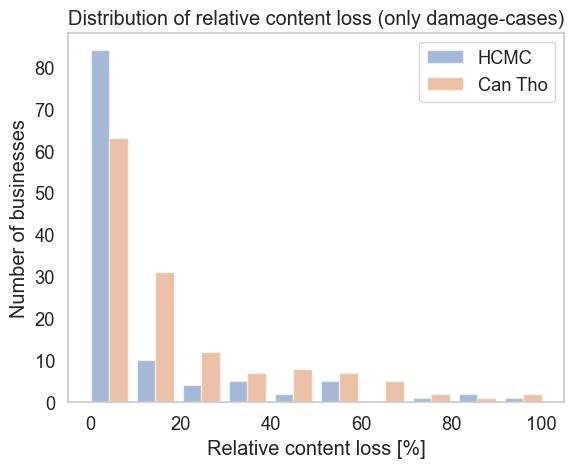

In [54]:
#bins = np.linspace(0, 100, 100)
#plt.hist(df_hcmc_bn["Target_businessreduction"], bins, alpha=0.7, label="HCMC")
#plt.hist(df_cantho["Target_businessreduction"], bins, alpha=0.7, label="Can Tho")

import seaborn as sns

# sns.set_theme()  # <-- This actually changes the look of plots.
sns.set_style("whitegrid", {"axes.grid" : False})
fig, ax = plt.subplots()
plt.hist(
    [
        df_hcmc_bn[target], 
        df_cantho_d[target]
    ], 
    #color=["r","b"], 
    alpha=0.5,  
    label=["HCMC", "Can Tho"],
    bins = np.linspace(-1, 101, 11)
)

# TODO make to 10 bins with equal ranges

plt.legend(loc="upper right")
plt.ylabel("Number of businesses")
plt.xlabel("Relative content loss [%]")
plt.title("Distribution of relative content loss (only damage-cases)")# (source: survey datasets)
plt.show()

### predict chance of loss - CanTho

In [55]:
## predict chance of loss for CanTho

y_cantho_c_pred_proba = clf.predict_proba(df_cantho_c_X)  # probabilitiies and predicted class

y_cantho_c_pred = np.argmax(y_cantho_c_pred_proba, axis=1)
y_cantho_c_proba = np.take_along_axis(
    y_cantho_c_pred_proba, 
    np.expand_dims(y_cantho_c_pred, axis=1), 
    axis=1
)
y_cantho_proba = pd.DataFrame(y_cantho_c_proba)#.flatten()

# print(y_cantho_proba, y_cantho_pred)

print(f"Actual zero-loss: {len(np.where(df_cantho_c[target] == 0)[0])}, \nActual damage: {df_cantho_c.loc[df_cantho_c[target] > 0.0, : ].shape[0]} \n")
print(f"Predict as zero-loss: {len(np.where(y_cantho_c_pred == 0)[0])}, \nPredict as damage: {len(np.where(y_cantho_c_pred == 1)[0])} ")


Actual zero-loss: 145, 
Actual damage: 138 

Predict as zero-loss: 239, 
Predict as damage: 44 


### predict degree of loss - CanTho

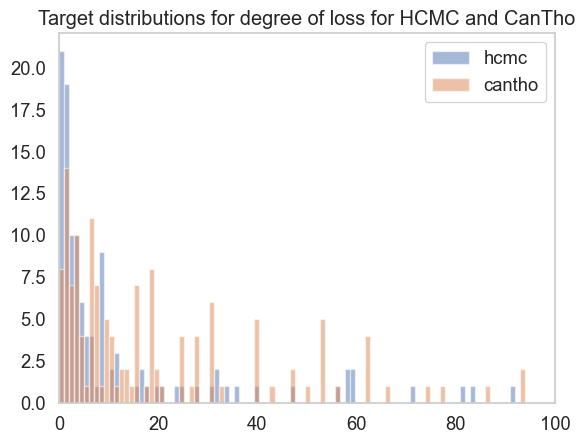

In [56]:
bins = np.linspace(0, 100, 100)

plt.hist(df_hcmc_bn[target], bins, alpha=0.5, label="hcmc")
plt.hist(df_cantho_d[target], bins, alpha=0.5, label="cantho")
plt.legend(loc="upper right")
plt.title("Target distributions for degree of loss for HCMC and CanTho")
plt.xlim(0,100)
plt.show()


In [57]:
condition=[1, 2, 3, 4 ,5,6]

df_cantho_d = df_cantho_d[df_hcmc_bn.columns] # give cantho DF same column order as for HCMC ds, DF inlcudes only predicted damage cases

values = df_cantho_d.iloc[:,condition].to_numpy() # data for conditionalization
# values = df_cantho_bn[df_hcmc_bn.columns].to_numpy() # data for conditionalization, only X, same variables as for BN contructed on HCMC

bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}


# BN build rank correlations from all damage-cases in HCMC dataset
R = bn_rankcorr(parent_cell,        # structure of the BN
    df_hcmc_bn,   # matrix of df_hcmc
    var_names = names,  # names of variables
    is_data = True,        # matrix data contains actual data
    plot = False) 

## get inference when BN transfered to Can Tho, predict degree of loss for Can THo 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from BN constructed for damage-cases in HCMC 
              df_cantho_d,     # unseen ds from CanTHo only with damage cases, same predictors as used to train the BN for HCMC
              Output="mean")    # type of output data
              #Output="median")    # type of output data

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_d.loc[:,target].to_numpy()


# evaluation metrics
MAE = eu.mean_absolute_error(y_true, y_pred)
MBE = eu.mean_bias_error(y_true, y_pred)
RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

## evaluate against test_nth_fold
bn_scores["MAE"].append(MAE)
bn_scores["MBE"].append(MBE)
bn_scores["RMSE"].append(RMSE)
bn_scores["SMAPE"].append(SMAPE)


print("Prediction performance for the degree of loss (Can Tho):" )  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

eu.empirical_vs_predicted(y_true, y_pred)

Inference - Uncertainty distribution:  count    138.000000
mean      15.467053
std        9.703416
min        0.983894
25%        8.232273
50%       13.201321
75%       20.461130
max       43.849773
dtype: float64
Prediction performance for the degree of loss (Can Tho):
MAE, MBE, RMSE, SMAPE: 17.26842649436064 -3.6583682070105104 24.273266137311097 48.47416938794495


,nobs,median,mean,min max,variance,standard deviation,coef variation
empirical,138,10.0,18.594203,"[0, 92]",449.18,21.12,113.980690
predicted,138,13.0,14.992754,"[0, 43]",94.52,9.69,64.844972


In [58]:
pred_d_cantho = pd.DataFrame(
            {
                "y_true": pd.Series(y_true),
                "y_pred": pd.Series(y_pred),
                "residuals": pd.Series(y_true) - pd.Series(y_pred),
            },
            index=pd.Series(y_true).index,
        )
print(pred_d_cantho.describe())


# for c in pred_d_cantho.columns:
#     ci = eu.calc_confidence_interval(pred_d_cantho[c], 0.95)


           y_true      y_pred   residuals
count  138.000000  138.000000  138.000000
mean    19.125421   15.467053    3.658368
std     21.229186    9.703416   24.083413
min      0.149707    0.983894  -43.232229
25%      3.419644    8.232273  -11.467977
50%     10.577460   13.201321   -1.400382
75%     27.884673   20.461130   11.242819
max     92.950717   43.849773   87.872613


In [59]:
# bins = np.linspace(0, 100, 100)

# plt.hist((pd.Series(pred_d_cantho.y_true.astype(int))), bins, alpha=0.5, label="empirical")
# plt.hist((pd.Series(pred_d_cantho.y_pred.astype(int))), bins, alpha=0.5, label="predicted")
# plt.legend(loc="upper right")
# plt.title("Target distributions for CanTho (empirical and predicted)")
# plt.show()


### get relative content loss estimations (chance * degree of loss)

In [60]:
## index of damage cases
idx_damage = np.where(df_cantho_c_y == 1)[0]

## new col incl prediction of degree of loss, all non-damage cases are as 0 
df_cantho_pred_cd = df_cantho_incl_zero
pred_target = f"pred_{target}"
df_cantho_pred_cd[pred_target] = 0.0 
df_cantho_pred_cd.loc[idx_damage, pred_target] = y_pred  ## add predicted degree of loss to df
df_cantho_pred_cd.loc[idx_damage, "degree_pred"] = y_pred  # BN results for degree needed for abs. degree of loss

# print(df_cantho_pred_cd[[target, pred_target]].describe())
# print(df_cantho_incl_zero[target].describe())



## pred_d_cantho  # degree of damages
## y_cantho_proba # chance that instance is a damage-case

## get estimation of relative content loss
df_cantho_pred_cd[pred_target] = df_cantho_pred_cd[pred_target] * y_cantho_c_proba.squeeze()  # risk = damage [%] * chance [0,1]
df_cantho_pred_cd[pred_target].describe()


## add binary observation and prediction of chance of loss
df_cantho_pred_cd["observed chance of closs"] = 0.0
df_cantho_pred_cd.loc[idx_damage, "observed chance of closs"] = 1
df_cantho_pred_cd[f"predicted chance of closs"] = y_cantho_c_pred
df_cantho_pred_cd[[target, pred_target,"degree_pred", "observed chance of closs", "predicted chance of closs"]].describe()



,Target_relative_contentloss_euro,pred_Target_relative_contentloss_euro,degree_pred,observed chance of closs,predicted chance of closs
count,283.000000,283.000000,138.000000,283.000000,283.000000
mean,9.326177,7.496308,15.467053,0.487633,0.155477
std,17.625553,10.201723,9.703416,0.500732,0.363001
min,0.000000,0.000000,0.983894,0.000000,0.000000
25%,0.000000,0.000000,8.232273,0.000000,0.000000
50%,0.000000,0.000000,13.201321,0.000000,0.000000
75%,9.600492,12.675670,20.461130,1.000000,0.000000
max,92.950717,43.849773,43.849773,1.000000,1.000000


## Evaluation of rcloss estimations -Can THo

In [61]:
## get ratio of damage cases vs total reported bred

c = df_cantho_pred_cd[target]
print(len(np.where(c > 0.0)[0])) 
print(len(np.where(c > 0.0)[0]) / len(c) * 100, "%")
np.mean(c)


138
48.76325088339223 %


9.326177176181371

In [62]:
## TODO make less but more consistent var names ,eg replace rcloss_ture with respective column from df_cantho_pred_cd

rcloss_true = df_cantho_pred_cd[target]
rcloss_pred = df_cantho_pred_cd[pred_target]

# evaluation metrics
MAE = eu.mean_absolute_error(rcloss_true, rcloss_pred)
MBE = eu.mean_bias_error(rcloss_true, rcloss_pred)
RMSE = eu.root_mean_squared_error(rcloss_true, rcloss_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(rcloss_true, rcloss_pred)


print("MAE,:", MAE)  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  


#print("\n", 
eu.empirical_vs_predicted(rcloss_true, rcloss_pred)


MAE,: 8.393276546518157
MAE, MBE, RMSE, SMAPE: 8.393276546518157 -1.8298693655509024 16.917789267365393 23.590257666171542


,nobs,median,mean,min max,variance,standard deviation,coef variation
empirical,283,0.0,9.067138,"[0, 92]",304.91,17.43,192.580964
predicted,283,0.0,7.257951,"[0, 43]",100.48,10.01,138.112191


In [63]:
print("Rcloss, cantho")
print(df_cantho_pred_cd[[target, pred_target]].describe())

for c in df_cantho_pred_cd[[target, pred_target]].columns:
    ci = eu.calc_confidence_interval(df_cantho_pred_cd[c], 0.95)


Rcloss, cantho
       Target_relative_contentloss_euro  pred_Target_relative_contentloss_euro
count                        283.000000                             283.000000
mean                           9.326177                               7.496308
std                           17.625553                              10.201723
min                            0.000000                               0.000000
25%                            0.000000                               0.000000
50%                            0.000000                               0.000000
75%                            9.600492                              12.675670
max                           92.950717                              43.849773
confidence interval: (7.263812202848018, 11.388542149514723) 
cases within interval: 17
confidence interval: (6.302604845938426, 8.690010775322508) 
cases within interval: 17


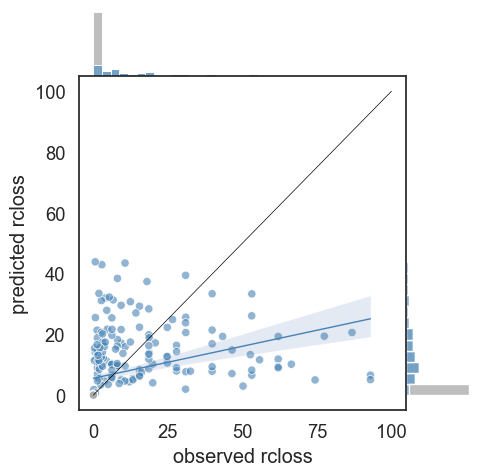

In [64]:
f.plot_observed_predicted(
    df_cantho_pred_cd[target], df_cantho_pred_cd[pred_target],  
    hue = df_cantho_pred_cd["observed chance of closs"],
    #hue=df_cantho_pred_cd[f"predicted chance of closs"],
    xlabel=f"observed {target_plot}", ylabel=f"predicted {target_plot}",
    legend=False, #True
    outfile=rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\figures\scatter_obs_pred_{target_plot}_cantho.png"
)       


In [65]:
# bins = np.linspace(0, 100, 100)
# plt.hist(df_hcmc_bn[target], bins, alpha=0.5, label="hcmc rcloss")
# plt.hist(df_cantho[target], bins, alpha=0.5, label="cantho rcloss")
# plt.legend(loc="upper right")
# plt.title("Target distributions for both cities (empirical)")
# plt.show()


### Main validation results

Compare with Chinh 2016 for ChanTho closs:
aveg. content loss:
- mean (median) 24 (118) 

### Absolute degree of content loss

In [66]:
df_cantho_acloss = df_cantho_pred_cd.copy()
df_cantho_acloss["acloss_true"] = df_cantho_acloss[target] *  df_cantho_acloss["shp_content_value_euro"] / 100

## NOTE use here vulnerability rcloss (BN*chance)
# df_cantho_acloss["abs_degree_pred"] = df_cantho_acloss[pred_target] *  df_cantho_acloss["shp_content_value_euro"] / 100 
## NOTE use here BN result (degree of loss)
df_cantho_acloss["abs_degree_pred"] = df_cantho_acloss["degree_pred"] *  df_cantho_acloss["shp_content_value_euro"] / 100 
print("abs_degree_pred has no zero-loss cases (min=", round(df_cantho_acloss["abs_degree_pred"].min(),2), ") and", df_cantho_acloss.shape[0],"damage cases")

## keep only damage cases to calc abs. degree of loss
print("check that osberved and predicted damage cases have the same index and can be therefore clipped by the index of one of both variables")
assert df_cantho_acloss.acloss_true[df_cantho_acloss["acloss_true"] > 0.0].index.all() == df_cantho_acloss.abs_degree_pred[df_cantho_acloss["abs_degree_pred"] > 0.0].index.all(), "not same idx in obs and pred degree of loss"

df_cantho_adegree = pd.DataFrame(columns=["abs_degree_true", "abs_degree_pred"]).reset_index(drop=True)
df_cantho_adegree["abs_degree_true"] = df_cantho_acloss["acloss_true"][df_cantho_acloss["acloss_true"] > 0.0]
df_cantho_adegree["abs_degree_pred"] = df_cantho_acloss["abs_degree_pred"][df_cantho_acloss["acloss_true"] > 0.0]  # remove all np.nan in "abs_degree_pred" (these are the zero-loss cases) by using idx from obs. zero-loss

print("Can Tho : absolute degree of content loss (only damage cases)")
print(eu.empirical_vs_predicted(df_cantho_adegree["abs_degree_true"], df_cantho_adegree["abs_degree_pred"]))


## add dummy binary var for plotting
df_cantho_adegree["abs_degree_true_dummy"] =  1.0   



## my results [n=283 businesses]  NOTE only damage-cases (degree of loss, used directly from BN output) 
## abs degree in HCMC   [n=114], mean (median): observed is 352.5€ (117.0) , predicted 575.1€ (352.0)
## abs degree in Cantho [n=138], mean (median): observed is 101.4€ (49.0) , predicted 201.3€ (61.5)  <-> Chinh16  135.9 € (27.6 €)

###########################################################################

## Can Tho : absolute degree of content loss (only damage cases)
#         nobs  median        mean    min max   variance      standard deviation     coef variation  
# empirical   138    49.0  101.413043   [2, 993]   20799.57           143.70           142.211065 
# predicted   138    61.5  203.173913  [2, 3346]  148487.12           383.94           191.488241      


## HCMC abs degree of loss
# #	       nobs	median	mean	    min max	   variance	standard deviation	coef variation
# empirical	114	117.0	352.517544	[7, 3618]	347977.77	587.30	        167.338171
# predicted	114	352.5	575.140351	[19, 6483]	812338.46	897.34	        156.709263

## Chinh 2016  [price level 2011]
## abs degree in Cantho, mean (median): observed 118 USD (24 USD )
#                    -->  final converted:      135.9 € (27.6 €) 	 in euro [2020]



abs_degree_pred has no zero-loss cases (min= 2.36 ) and 283 damage cases
check that osberved and predicted damage cases have the same index and can be therefore clipped by the index of one of both variables
Can Tho : absolute degree of content loss (only damage cases)
           nobs  median        mean    min max   variance  standard deviation   
empirical   138    49.0  101.413043   [2, 993]   20799.57              143.70  \
predicted   138    61.5  205.884058  [2, 3438]  159394.69              397.79   

           coef variation  
empirical      142.211065  
predicted      193.916249  


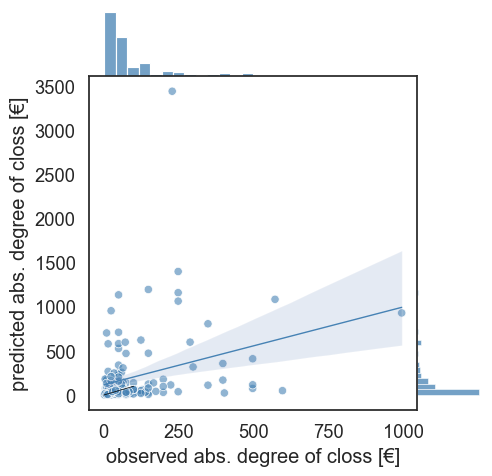

In [67]:
## TODO adapt x and y aixs to same limits -> use fixed max for xlim and ylim 
## TDO fix hue  all zero should be vertical  test mit =df_cantho_pred_cd["acloss_true"]as binary
plot_observed_predicted_abs(
    y_true=df_cantho_adegree["abs_degree_true"], y_pred=df_cantho_adegree["abs_degree_pred"], 
    hue=df_cantho_adegree["abs_degree_true_dummy"],
    # hue=df_cantho_pred_cd["predicted chance of closs"],
    xlabel=f"observed abs. degree of closs [€]", ylabel=f"predicted abs. degree of closs [€]",
    legend=False ,#True
    outfile=rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\figures\scatter_obs_pred_abs_degree_{target_plot}_cantho.png"
)     


In [68]:
## get  reported losses in CHinh 2016 from USD [2011] to Euro [2020]

# # GDP deflator source : https://jp.tradingeconomics.com/united-states/gdp-deflator
gdp_price_index_2011 = 91.48  # 2011  #  chinh 2016 uses 2011 as reference year
gdp_price_index_2020 = 105.37 # price level 2020 based on GDP-deflation

# for r in range(len(vars_money.Target_contentloss_VND)):
chinh16_results = pd.DataFrame({
    "mean_degree_closs_usd": [118], # price level 2011 in USD
    "median_degree_closs_usd": [24] ,# price level 2011 in USD
    "mean_degree_closs_euro": [None],
    "median_degree_closs_euro": [None],
})
for r in range(len(chinh16_results.mean_degree_closs_usd)):
    chinh16_results["mean_degree_closs_euro"][r] = round(chinh16_results["mean_degree_closs_usd"][r] * gdp_price_index_2020 / gdp_price_index_2011, 1)  # price level 2020 in Euro
    chinh16_results["median_degree_closs_euro"][r] = round(chinh16_results["median_degree_closs_usd"][r] * gdp_price_index_2020 / gdp_price_index_2011, 1)  # price level 2020 in Euro

chinh16_results

,mean_degree_closs_usd,median_degree_closs_usd,mean_degree_closs_euro,median_degree_closs_euro
0,118,24,135.9,27.6


NOtes to  abs loss Cnatho


In [69]:


# # ### Plot prediction error from outer cv
# f.plot_results(
#     results=predicted_values, 
#     model_names_abbreviation=["cforest", "ElasticNet", "XGBRegressor"],  
#     model_names_plot=["Conditional Random Forest", "Elastic Net", "XGBoost"],
#     outfile=f"../../model_results/models_evaluation/degree_of_loss/results_{target}.png"
# )


In [70]:
# bins = np.linspace(0, 100, 100)
# plt.hist(df_hcmc_bn[target], bins, alpha=0.5, label="hcmc rcloss")
# plt.hist(df_cantho[target], bins, alpha=0.5, label="cantho rcloss")
# plt.legend(loc="upper right")
# plt.title("Target distributions for both cities (empirical)")
# plt.show()


# Leftovers

### Scatterplot obs ~ pred

In [71]:
# from matplotlib.colors import to_rgba



# def plot_observed_predicted(y_true, y_pred, hue=None, xlabel="observed", ylabel="predicted", alpha=0.6, legend=False, outfile="test.png"):
#     """
#     Scatter plot of observations vs predictions with optional class colors
#     """
#     # Code Snippet: https://stackoverflow.com/questions/66667334/python-seaborn-alpha-by-hue

#     sns.set(style="white", font_scale=1.2)
    
#     color_dict = {
#         0: to_rgba('darkgrey', alpha), # set transparency for each class independently
#         1: to_rgba('steelblue', alpha)
#     }
    
#     g = sns.JointGrid(
#         x=y_true, y=y_pred, hue=hue,
#         height=5, space=0,)
#     # g.plot_joint(sns.scatterplot, palette=color_dict, edgecolors=color_dict, legend=legend)
#     p = sns.scatterplot(
#         x=rcloss_true, y=rcloss_pred, hue=hue, 
#         palette=color_dict, edgecolors=color_dict, legend=legend, 
#         ax=g.ax_joint)
    
#     if legend == True:
#         #p.legend(fontsize=10, )  # outside plot: bbox_to_anchor= (1.2,1)
#         plt.setp(p.get_legend().get_texts(), fontsize='12')  
#         plt.setp(p.get_legend().get_title(), fontsize='15')

#     g.plot_marginals(sns.histplot, kde=False, palette=color_dict, multiple='stack')

#     g1 = sns.regplot(
#         x=rcloss_true, y=rcloss_pred, 
#         line_kws={"lw":1.},
#         scatter=False, ax=g.ax_joint)
#     regline = g1.get_lines()[0]
#     regline.set_color('steelblue')

#     x0, x1 = (0, 100) 
#     y0, y1 = (0, 100)
#     lims = [min(x0, y0), max(x1, y1)]
#     g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
#     g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)

#     # save plot
#     plt.savefig( outfile, dpi=300, bbox_inches="tight")

#     plt.show()

#     # plt.setp(ax1.get_legend().get_texts(), fontsize='22') # for legend text
#     # plt.suptitle("HCMC: Estimation of relative content loss")
#     # plt.tight_layout()
#     # plt.show()


In [72]:
## #FLO'S fancy scatterplot with histos 

# import math

# from matplotlib.gridspec import GridSpec
# import mpl_scatter_density # adds projection="scatter_density"
# from matplotlib.colors import LinearSegmentedColormap


# def create_bins(y, bin_size=1):
#     # lower bound inclusive
#     min_age = math.floor(y.min())
#     # upper bound inclusive for histogram plotting, exclusive for categorizing variables
#     max_age = math.ceil(y.max())
#     return list(range(min_age, max_age + 1))[0::bin_size]

# # age_bins(y_pred_org["y_true"])


# def plot_relative_grid(y_true, y_pred, bin_size=5, **kwargs):

#     bins = create_bins(y_pred, bin_size=bin_size)
#     ticks = [0, 20, 40, 60, 80, 100]
#     X, Y = np.meshgrid(bins, bins)
#     H = np.histogram2d(y_true, y_pred, bins=bins)[0]
#     # H_norm: each row describes relative share of all prediction loss bands for businesses of a certain test band
#     H_norm = (H.T / H.sum(axis=1)).T

#     fig = plt.figure(figsize=(8, 8))
#     gs = GridSpec(4, 4)

#     ax_scatter = fig.add_subplot(gs[1:4, 0:3])
#     ax_hist_x = fig.add_subplot(gs[0,0:3])
#     ax_hist_y = fig.add_subplot(gs[1:4, 3])

#     cmap = LinearSegmentedColormap.from_list("", ["white", "steelblue"])
#     colors = ["lightsteelblue", "lightsteelblue", "plum"]

#     ax_scatter.plot([0, 1], [0, 1], transform=ax_scatter.transAxes, color="darkgrey")
#     ax_scatter.pcolormesh(Y,X, H_norm, cmap=cmap, rasterized=True)   # modified to have y_pred on y-axis
#     ax_scatter.set_yticks(ticks, labels=ticks)
#     ax_scatter.set_xticks(ticks, labels=ticks)

#     ax_hist_x.hist(y_true, bins=bins, color=colors[0], alpha=0.7)
#     ax_hist_y.hist(y_pred, bins=bins, orientation="horizontal", color=colors[0], alpha=0.7)

#     ax_hist_x.set_axis_off()
#     ax_hist_y.set_axis_off()
#     fig.subplots_adjust(hspace=0.05, wspace=0.02)

#     ax_scatter.spines["top"].set_linewidth(0.5)
#     ax_scatter.spines["right"].set_linewidth(0.5)
#     ax_scatter.spines["left"].set_linewidth(0.5)
#     ax_scatter.spines["bottom"].set_linewidth(0.5)

#     ax_scatter.set_xlabel("Observed")
#     ax_scatter.set_ylabel("Predicted")
#     # fig.colorbar(ax_scatter, label="Number of points per pixel", orientation="horizontal")

#     plt.suptitle("HCMC: Estimation of relative content loss")

# plot_relative_grid(rcloss_true, rcloss_pred, bin_size=2)

# # TODO rmeove shift to right 
# # TODO implement colorbar horizontal with Number of points per pixel

In [73]:

# sns.set(style="white", font_scale=1.2)

# fig = plt.figure(figsize=(10,10))
# # ax = fig.add_subplot(1, 1, 1, projection="scatter_density")


# g = sns.JointGrid(
#     x=degree_results["y_true"], y=degree_results["y_pred"], 
#     height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
# ) #aspect=1.5            # Initiate multi-plot
# g.plot_joint(sns.regplot) 
# # cb = fig.colorbar(g, label="counts") # ax=ax 

# g.plot_marginals(
#     sns.distplot, color="black", #kind="kde",
#     kde=True, hist=False, #rug=True, 
#     kde_kws={"color": "red", "cut": 0.0, "lw": 1},
# )
# g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
#                     lw=1, #alpha=.005
#                 )
# # density = ax.scatter_density(
# #     x=bn_degree_true_pred["y_true"], y=bn_degree_true_pred["y_pred"], 
# #     cmap=white_viridis
# # )
# # fig.colorbar(density, label="Number of points per pixel")

# x0, x1 = (0, 100) 
# y0, y1 = (0, 100)
# lims = [min(x0, y0), max(x1, y1)]
# g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
# plt.suptitle(f"HCMC degree of loss, based on {degree_results.shape[0]} samples")

# # hb = ax.hexbin(
# #     x=bn_degree_true_pred["y_true"], y=bn_degree_true_pred["y_pred"], 
# #     gridsize=10, cmap="viridis")
# # ax.set(xlim=(0, 100) , ylim=(0, 100) )
# # # ax.set_title("Hexagon binning")
# # cb = fig.colorbar(hb, ax=ax, label="counts")


# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.show()


In [74]:
# cantho

# sns.set(style="white", font_scale=1.2)


# g = sns.JointGrid(
#     x=y_true, y=y_pred, 
#     # x=pred_d_cantho["y_true"], y=pred_d_cantho["y_pred"], 
#     height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
# ) #aspect=1.5            # Initiate multi-plot
# g.plot_joint(sns.regplot) 

# g.plot_marginals(
#     sns.distplot, color="black", #kind="kde",
#     kde=True, hist=False, #rug=True, 
#     kde_kws={"color": "red", "cut": 0.0, "lw": 1},
# )
# g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
#                     lw=1, #alpha=.005
#                 )
              
# x0, x1 = (0, 100) 
# y0, y1 = (0, 100)
# lims = [min(x0, y0), max(x1, y1)]
# g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.show()

###################################

# g = sns.JointGrid(
#     x=rcloss_true, 
#     y=rcloss_pred, 
#     height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
# ) #aspect=1.5            # Initiate multi-plot
# g.plot_joint(sns.regplot) 

# g.plot_marginals(
#     sns.distplot, color="black", #kind="kde",
#     kde=True, hist=False, #rug=True, 
#     kde_kws={"color": "red", "cut": 0.0, "lw": 1},
# )
# g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
#                     lw=1, #alpha=.005
#                 )
              
# x0, x1 = (0, 100) 
# y0, y1 = (0, 100)
# lims = [min(x0, y0), max(x1, y1)]
# g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.suptitle("Can Tho: Estimation of relative content loss")
# plt.show()

#### Inference

In [75]:
# #-----------------------------------------------------------------------------
# # Function 5 - inference - making inference with the BN model
# #-----------------------------------------------------------------------------

# condition=[1] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
# values = df_hcmc_bn.iloc[:,condition].to_numpy() # data for conditionalization

# F = inference(condition,        # nodes that will be conditionalized
#               values,           # information used to conditionalize the
#                                 # nodes of the NPBN
#               R,                # the rank correlation matrix 
#               df_hcmc_bn, # DataFrame with df_hcmc
#              # Output="mean")    # type of output data
#               Output="median")    # type of output data

# print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

# ## predict target
# y_pred = F.squeeze()

# # Fill out the column(s) which are predicted
# y_true=df_hcmc_bn.iloc[:,0].to_numpy()

# # Calculate coefficient of determination
# A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
# B = (y_true - y_true.mean(axis=0))/y_true.std(axis=0)
# correlation = (np.dot(B, A.T)/B.shape[0])
# R2=correlation**2

# # Calculate evaluation metrics
# MAE = np.mean(np.abs(y_pred-y_true))
# MBE = np.mean(y_pred-y_true)
# RMSE = (np.mean((y_pred-y_true)**2))**(1/2)

# print("MAE,:", MAE)  
# print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  
